### **Importing Libraries**

In fraud detection, Recall for the minority class (1) is generally prioritized to ensure actual fraud is not missed, while ROC-AUC measures the model's overall ability to distinguish between classes.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB 
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import warnings

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    recall_score,
    fbeta_score
)

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

### **Loading Data**

In [11]:
import joblib
from joblib import load

X_train, y_train, X_test, y_test = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\dataset_joblib_files\ORIGINAL_TRANSFORMED_dataset_splits.joblib')

In [4]:
import joblib
from joblib import load

X_train1, y_train1, X_test1, y_test1 = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\dataset_joblib_files\dataset_splits.joblib')

In [20]:
def train_and_evaluate_fraud_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test
):
    """
    Trains and evaluates a fraud detection model with full metrics and plots.
    """

    # -----------------------------
    # Train model
    # -----------------------------
    model.fit(X_train, y_train)

    # -----------------------------
    # Model info
    # -----------------------------
    print("="*70)
    print("MODEL USED:")
    print(model)
    print("="*70)

    # -----------------------------
    # Predictions
    # -----------------------------
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]

    # -----------------------------
    # Confusion matrices
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    # -----------------------------
    # Metrics
    # -----------------------------
    roc_auc = roc_auc_score(y_test, y_probs)

    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)

    fraud_recall = recall_score(y_test, y_pred, pos_label=1)
    f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

    # -----------------------------
    # Print metrics
    # -----------------------------
    print("Confusion Matrix (Counts):\n", cm)
    print("\nConfusion Matrix (Normalized %):\n", np.round(cm_norm * 100, 2))

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Fraud Recall: {fraud_recall:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # -----------------------------
    # Confusion matrix plots
    # -----------------------------
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plt.figure(figsize=(6,6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues')
    plt.title("Confusion Matrix (Normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # -----------------------------
    # ROC Curve
    # -----------------------------
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # -----------------------------
    # Precision-Recall Curve
    # -----------------------------
    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    # -----------------------------
    # Return results
    # -----------------------------
    return model, {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "fraud_recall": fraud_recall,
        "f2_score": f2
    }

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    balanced_accuracy_score, confusion_matrix, fbeta_score,
    roc_auc_score, precision_recall_curve, auc, roc_curve,
    ConfusionMatrixDisplay
)

# ======================================================
# 1. Initialize report dictionary
# ======================================================

report = {
    'Sampling': [],
    'model_name': [],

    # Raw counts
    'TP': [], 'FP': [], 'TN': [], 'FN': [],

    # Normalized rates
    'TP_rate': [], 'FP_rate': [],
    'TN_rate': [], 'FN_rate': [],

    'accuracy': [],
    'balanced_accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'f0.5': [],
    'f2.0': [],
    'roc_auc': [],
    'pr_auc': []
}

# ======================================================
# 2. Display report
# ======================================================

def display_report():
    return pd.DataFrame(report)

# ======================================================
# 3. Main evaluation function
# ======================================================

def evaluate(technique, modelname, Model, X_train, y_train, X_test, y_test):

    # Avoid duplicates
    df = display_report()
    if not df.empty:
        df['id'] = df['Sampling'] + df['model_name']
        if technique + modelname in df['id'].values:
            print("Preexisting model — skipping.")
            return

    print("="*70)
    print(f"Training: {Model}")
    print("="*70)

    # -----------------------------
    # Train
    # -----------------------------
    Model.fit(X_train, y_train)

    # -----------------------------
    # Predictions
    # -----------------------------
    y_pred = Model.predict(X_test)
    y_probs = Model.predict_proba(X_test)[:, 1]

    # -----------------------------
    # Confusion matrices
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    tn_r, fp_r = cm_norm[0]
    fn_r, tp_r = cm_norm[1]

    # -----------------------------
    # Metrics
    # -----------------------------
    acc = accuracy_score(y_test, y_pred)
    bl_acc = balanced_accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    f_05 = fbeta_score(y_test, y_pred, beta=0.5)
    f_2 = fbeta_score(y_test, y_pred, beta=2.0)

    roc_auc = roc_auc_score(y_test, y_probs)

    pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(pr_rec, pr_prec)

    # -----------------------------
    # Store in report
    # -----------------------------
    report['Sampling'].append(technique)
    report['model_name'].append(str(Model))

    report['TP'].append(tp)
    report['FP'].append(fp)
    report['TN'].append(tn)
    report['FN'].append(fn)

    report['TP_rate'].append(tp_r)
    report['FP_rate'].append(fp_r)
    report['TN_rate'].append(tn_r)
    report['FN_rate'].append(fn_r)

    report['accuracy'].append(acc)
    report['balanced_accuracy'].append(bl_acc)
    report['recall'].append(recall)
    report['precision'].append(precision)
    report['f1'].append(f1)
    report['f0.5'].append(f_05)
    report['f2.0'].append(f_2)
    report['roc_auc'].append(roc_auc)
    report['pr_auc'].append(pr_auc)

    # ======================================================
    # Plots
    # ======================================================

    # Raw CM
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title(f"{modelname} — Counts")
    plt.show()

    # Normalized CM
    ConfusionMatrixDisplay(cm_norm).plot(cmap='Blues', values_format=".2%")
    plt.title(f"{modelname} — Normalized")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title(f"ROC — {modelname}")
    plt.legend()
    plt.show()

    # PR Curve
    plt.figure(figsize=(5,5))
    plt.plot(pr_rec, pr_prec, label=f"PR-AUC={pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve — {modelname}")
    plt.legend()
    plt.show()

    print(f"Completed: {modelname}")


In [22]:
def get_models():
  models, names = list(), list()

    # GNB
  models.append(LogisticRegression())
  names.append('LogisticRegression')

  # GNB
  models.append(GaussianNB())
  names.append('Gaussian NaiveBayes')

  # DecisionTreeClassifier
  models.append((DecisionTreeClassifier()))
  names.append('DecisionTree Classifier')

  #RandomForestClassifier
  models.append(RandomForestClassifier())
  names.append('RandomForest Classifier')

  # GradientBoostingClassifier
  models.append(GradientBoostingClassifier())
  names.append('GradientBoosting Classifier')

  #BaggingClassifier
  models.append(BaggingClassifier())
  names.append('Bagging Classifier')

  #XgbClassifier
  models.append(xgb.XGBClassifier())
  names.append('XGBClassifier Classifier')

  #AdaBoostClassifier
  models.append(AdaBoostClassifier())
  names.append('AdaBoostClassifier Classifier')

  #CatBoost Classifier
  models.append(CatBoostClassifier(silent=True))
  names.append('CatBoostClassifier')

  #LGBM
  models.append(lgb.LGBMClassifier())
  names.append('LGBM Classifier')

  # stacking classifier
  estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

  stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

  models.append(stacking_class)
  names.append('Stacking Class')



  return models, names

## **Modeling**

#### Original Data

Training: LogisticRegression()


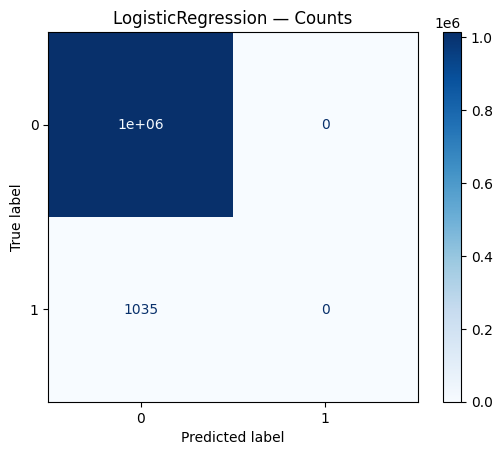

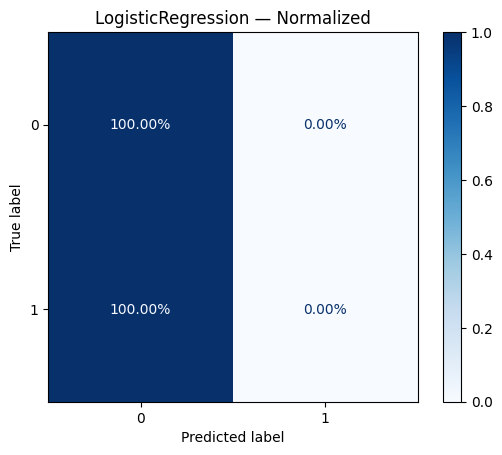

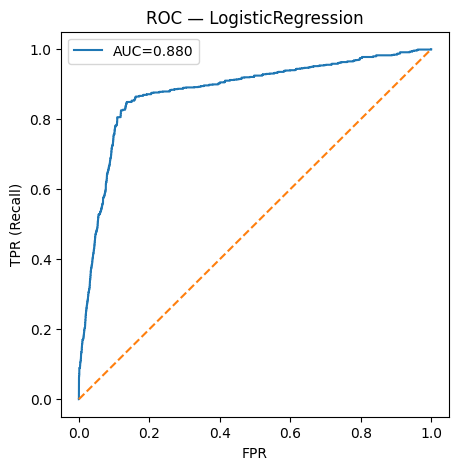

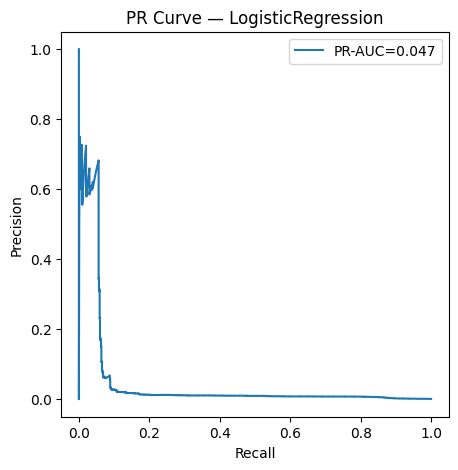

Completed: LogisticRegression
Training: GaussianNB()


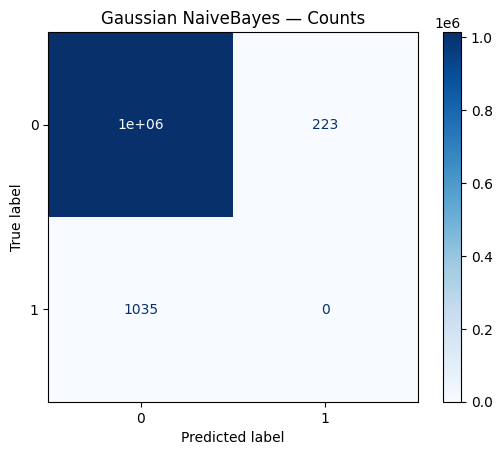

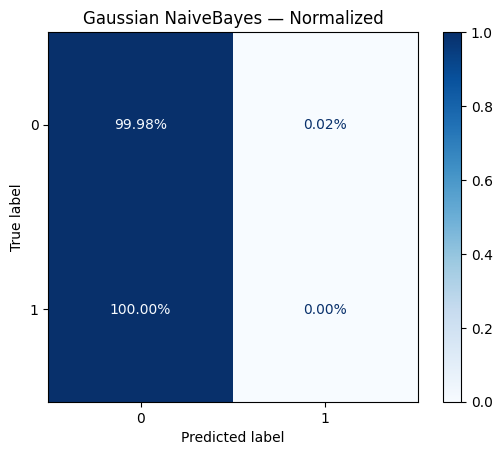

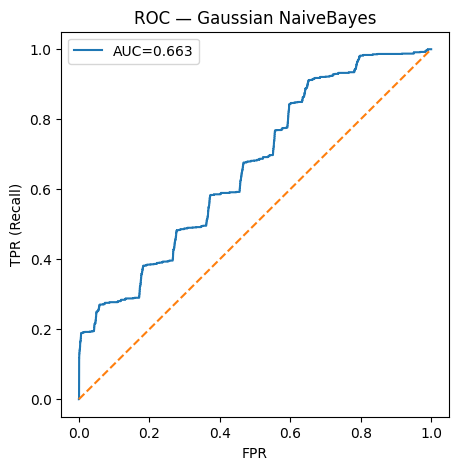

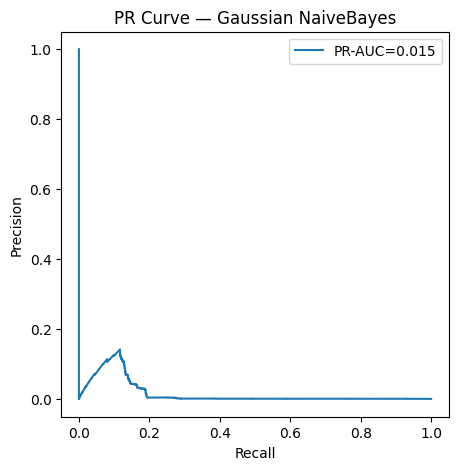

Completed: Gaussian NaiveBayes
Training: DecisionTreeClassifier()


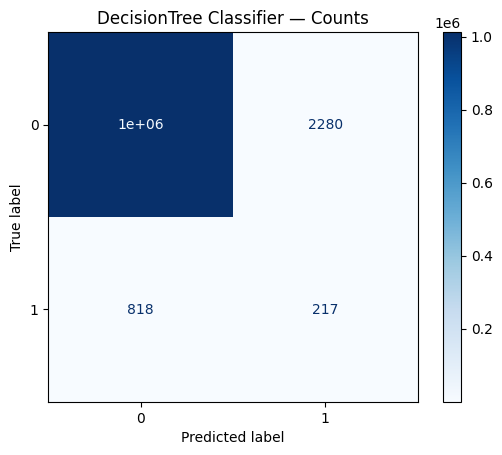

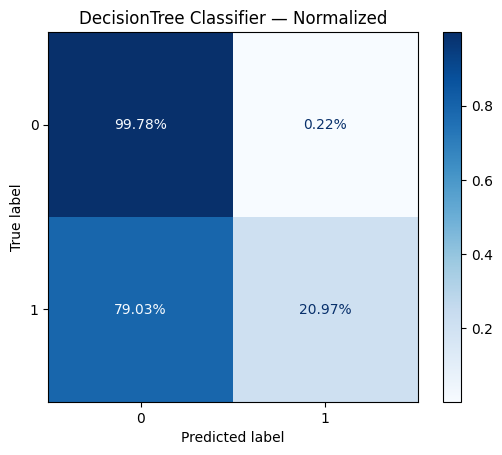

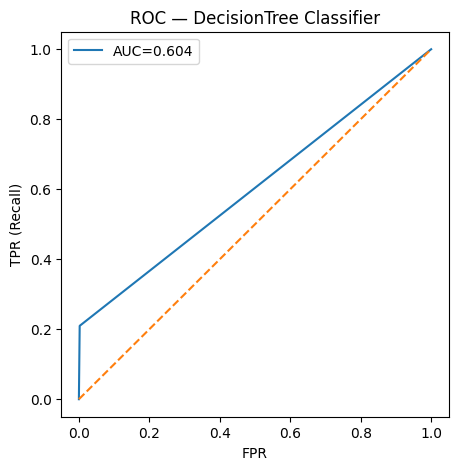

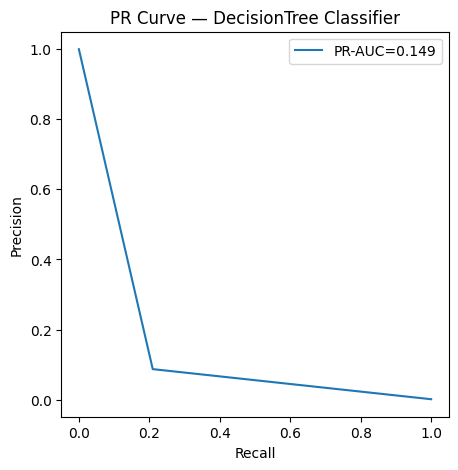

Completed: DecisionTree Classifier
Training: RandomForestClassifier()


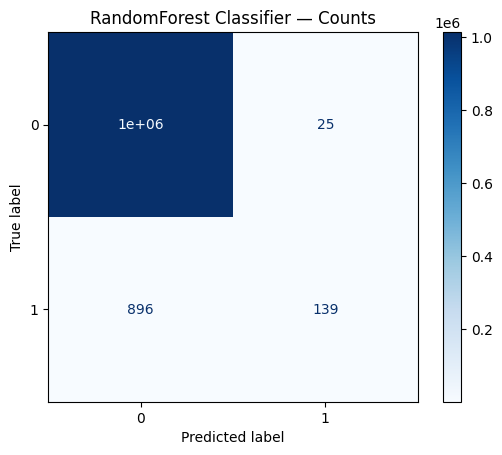

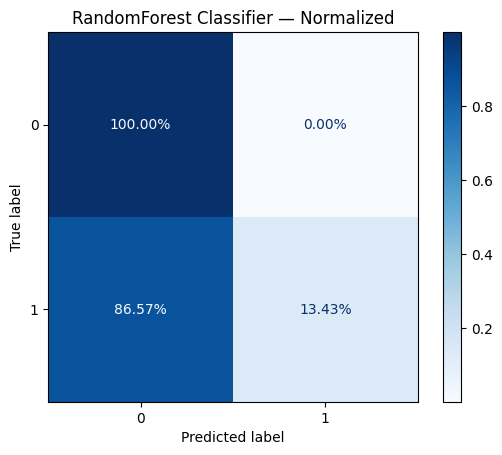

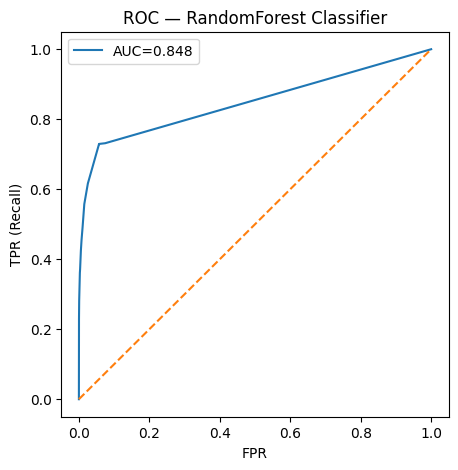

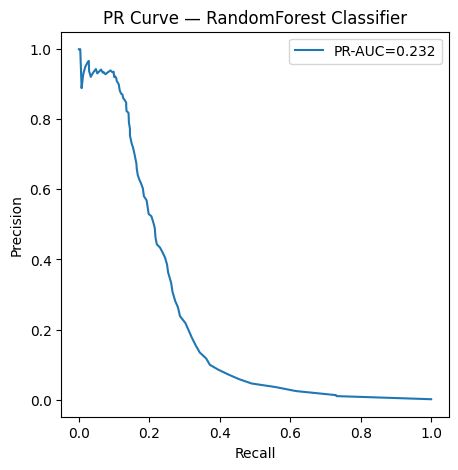

Completed: RandomForest Classifier
Training: GradientBoostingClassifier()


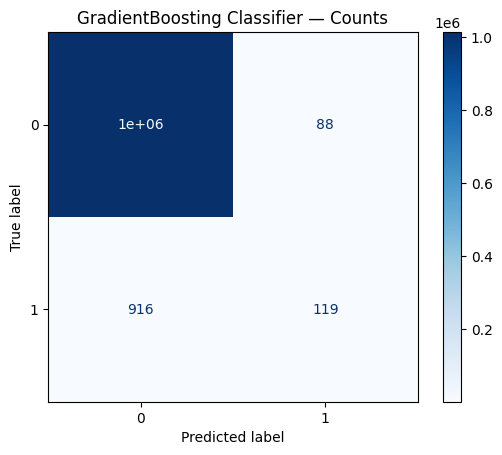

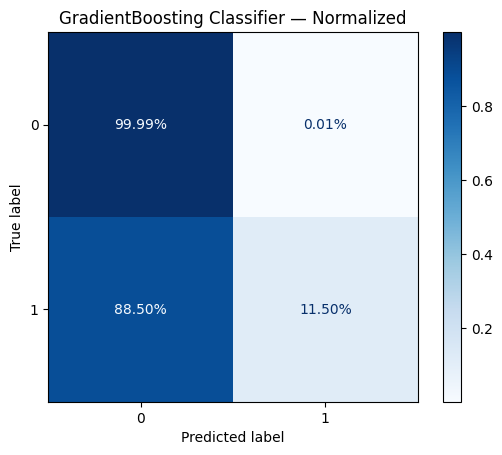

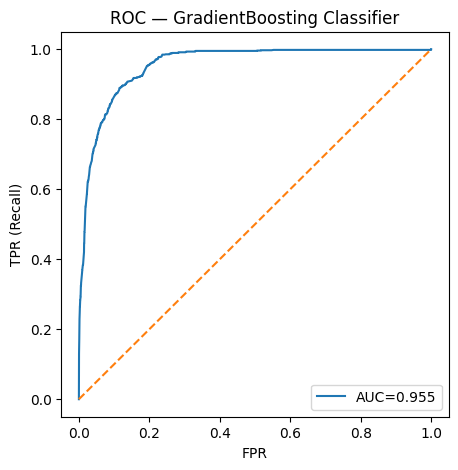

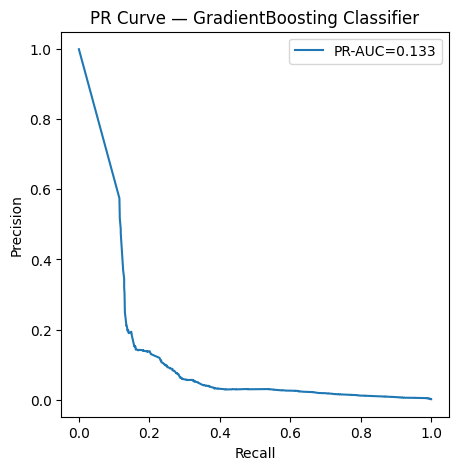

Completed: GradientBoosting Classifier
Training: BaggingClassifier()


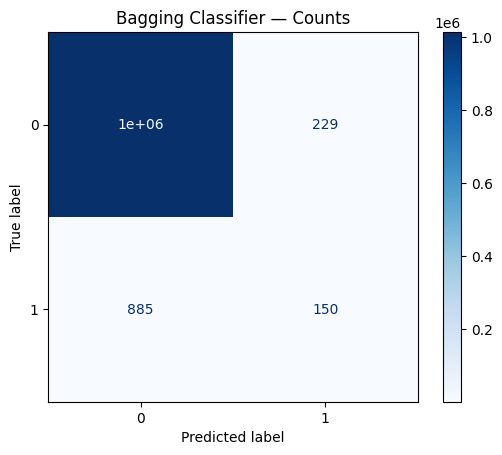

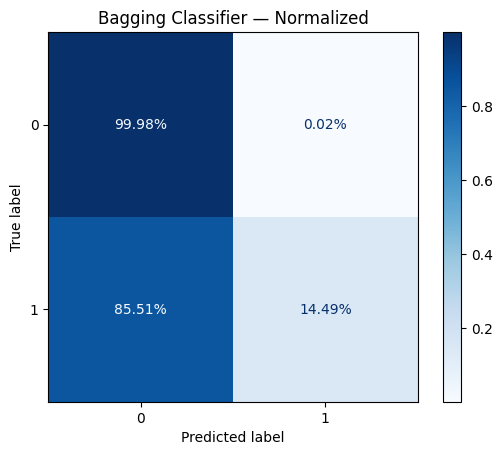

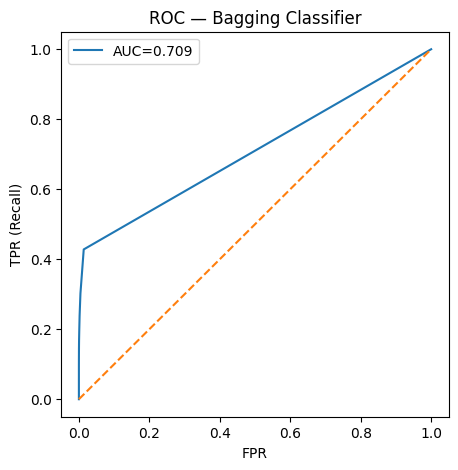

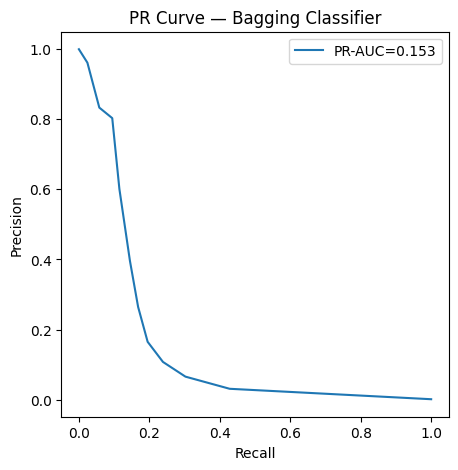

Completed: Bagging Classifier
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


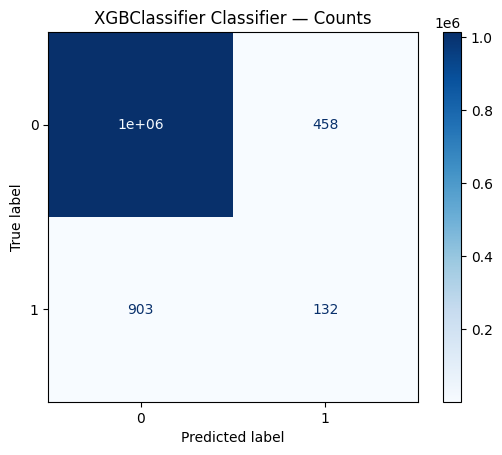

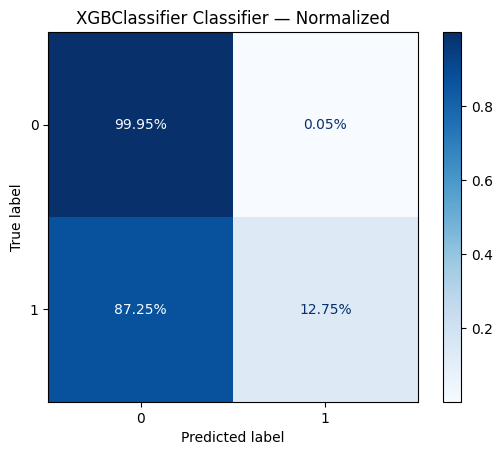

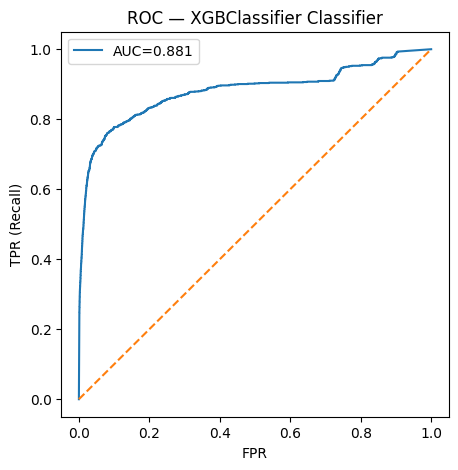

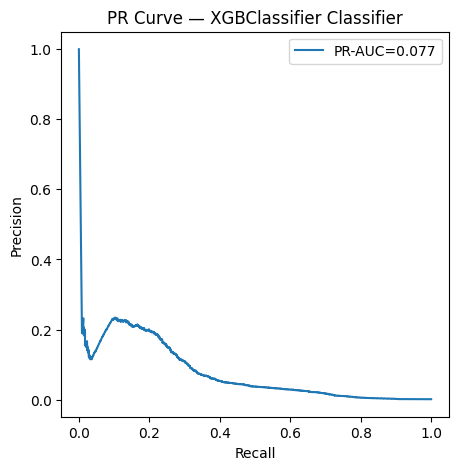

Completed: XGBClassifier Classifier
Training: AdaBoostClassifier()


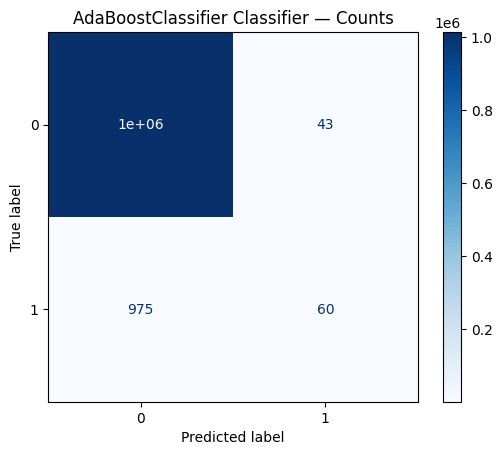

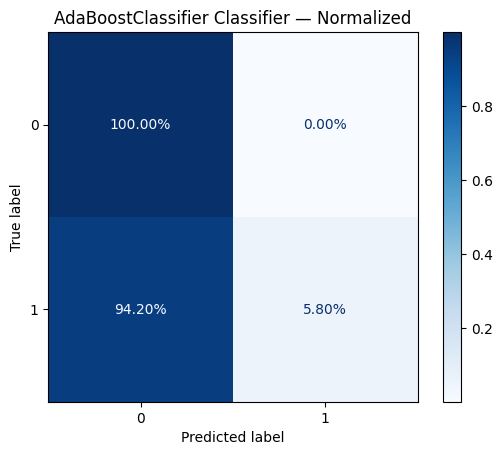

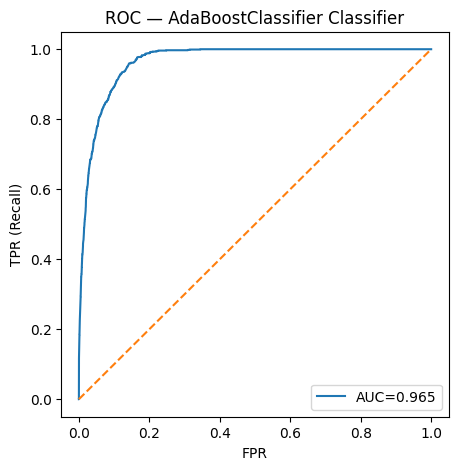

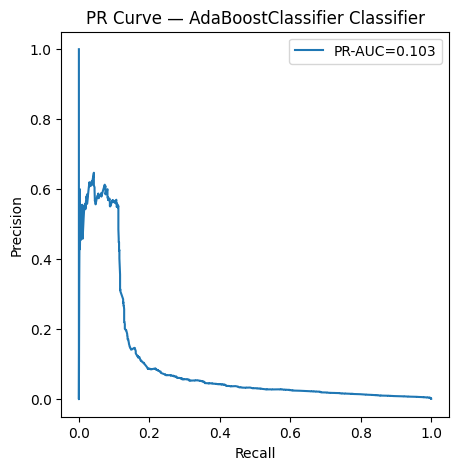

Completed: AdaBoostClassifier Classifier
Training: <catboost.core.CatBoostClassifier object at 0x000001AFEEEC33D0>


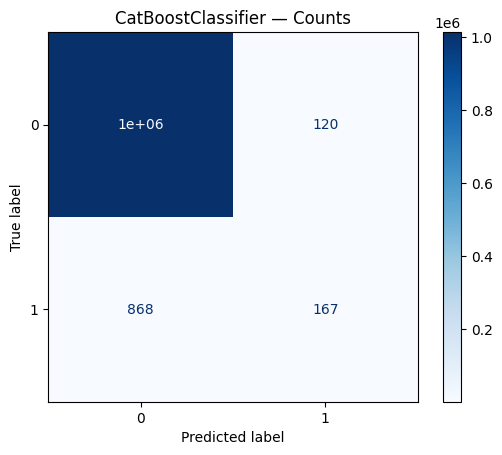

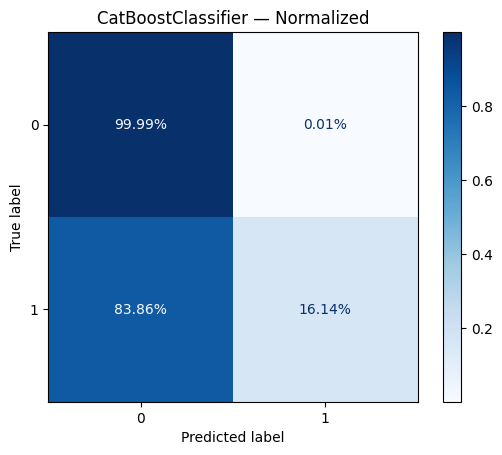

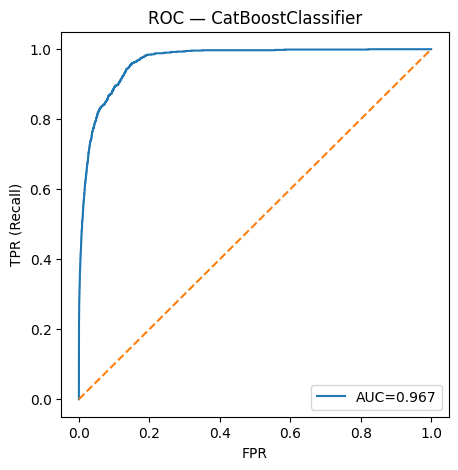

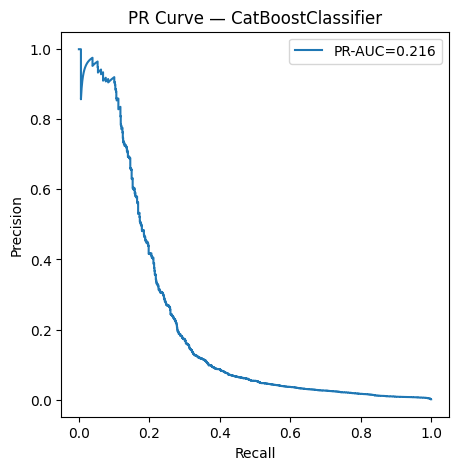

Completed: CatBoostClassifier
Training: LGBMClassifier()
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4142, number of negative: 4058534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 4062676, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001020 -> initscore=-6.887398
[LightGBM] [Info] Start training from score -6.887398


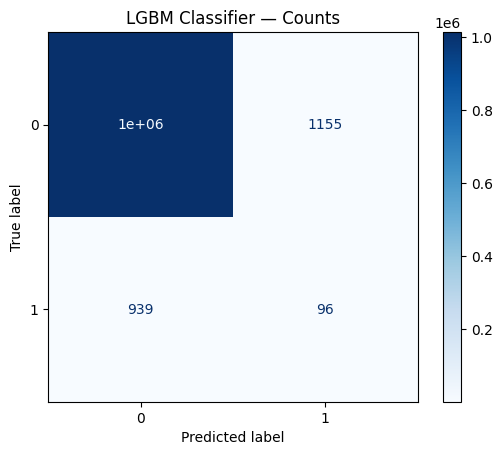

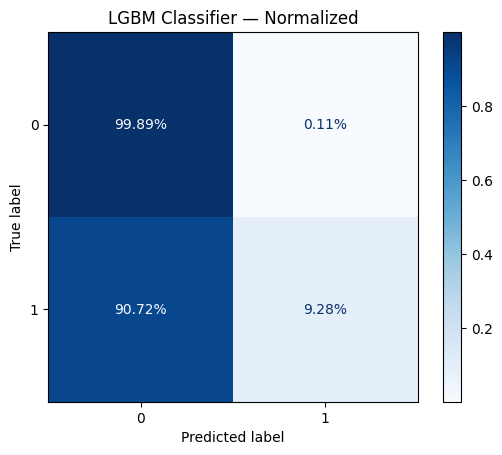

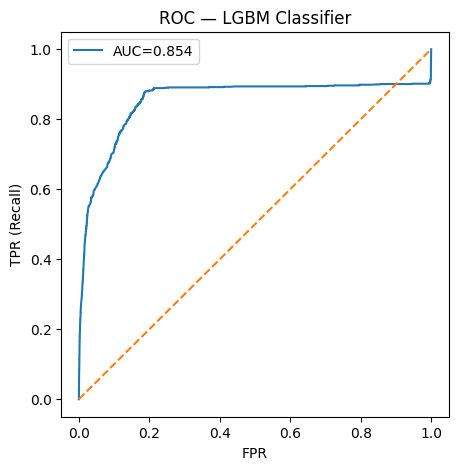

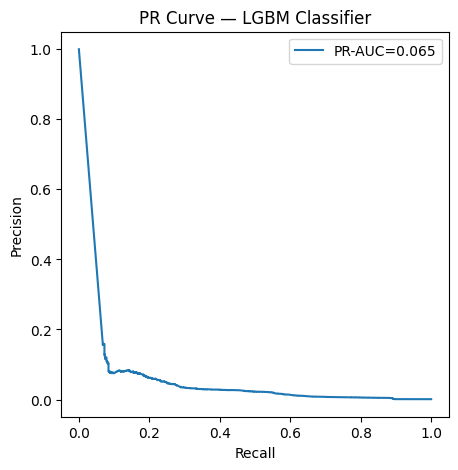

Completed: LGBM Classifier
Training: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())


KeyboardInterrupt: 

In [12]:
models, names = get_models()
for i in range(len(models)):
  evaluate("None", names[i], models[i],X_train, y_train, X_test,y_test)
display_report()

#### Undersampled Data

Training: LogisticRegression()


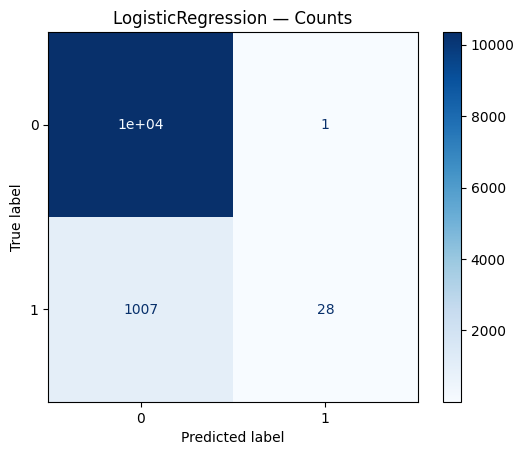

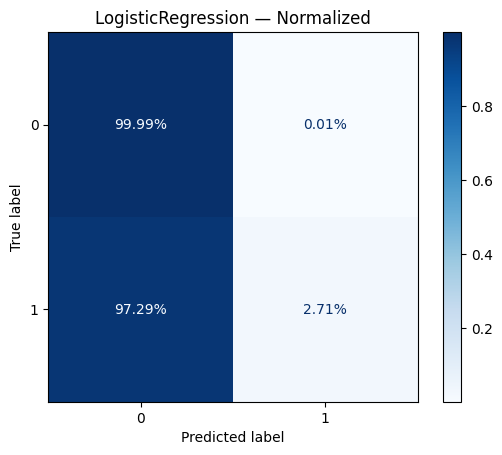

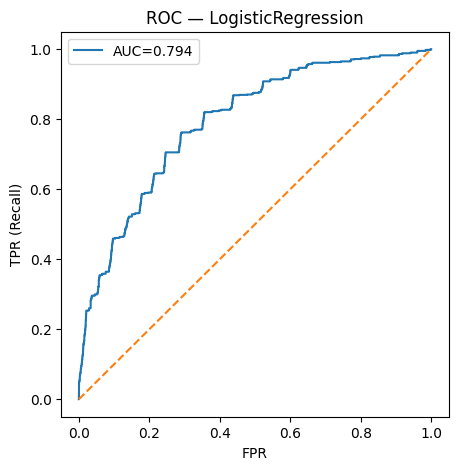

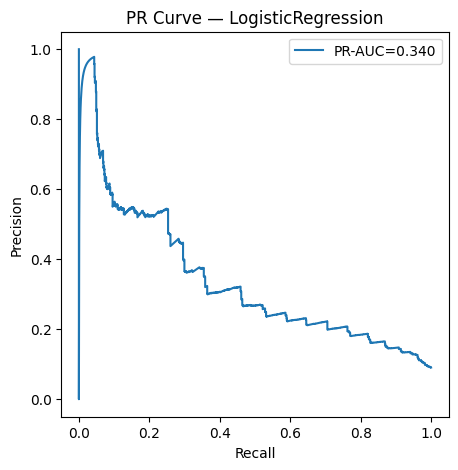

Completed: LogisticRegression
Training: GaussianNB()


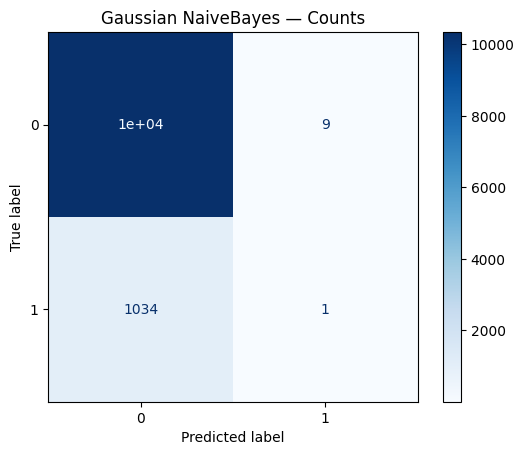

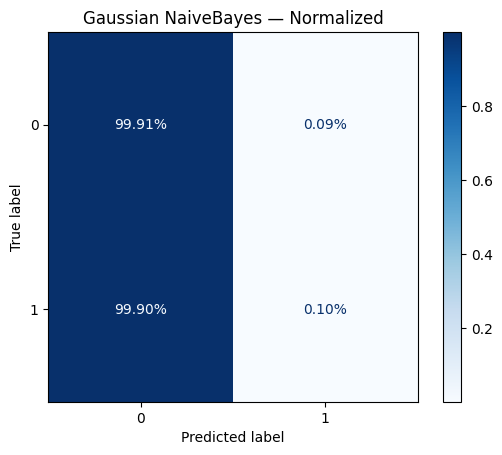

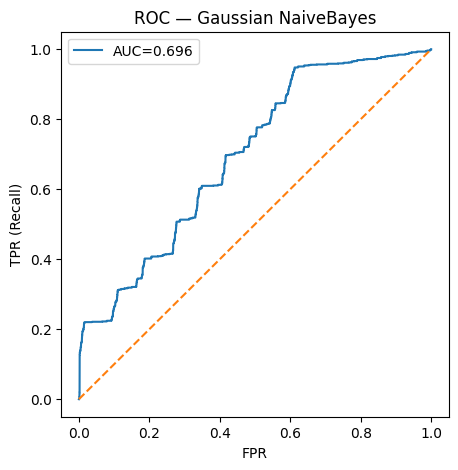

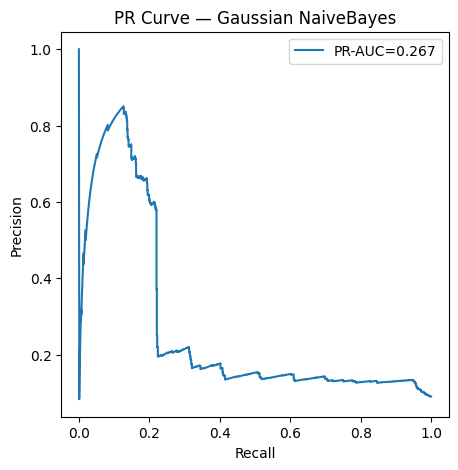

Completed: Gaussian NaiveBayes
Training: DecisionTreeClassifier()


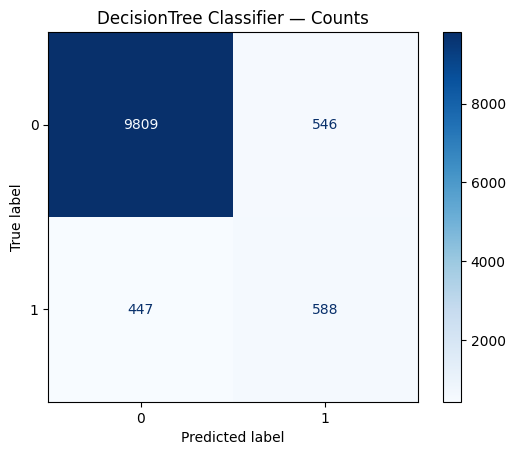

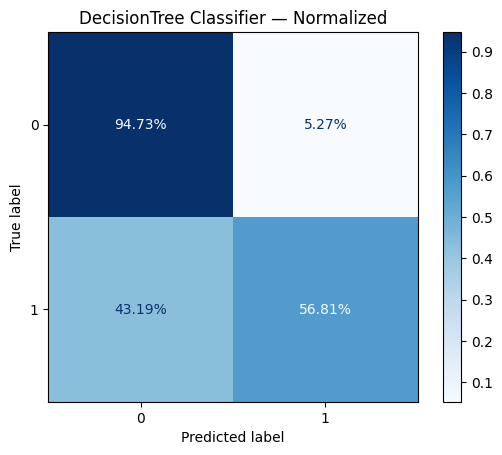

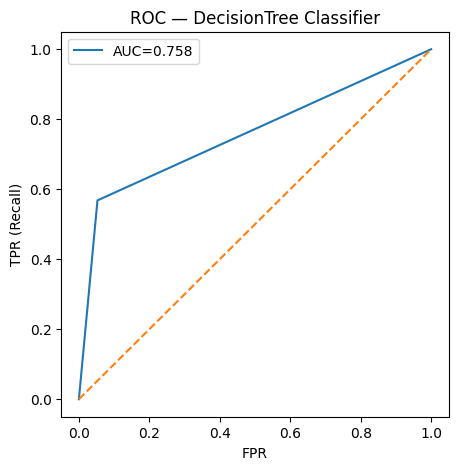

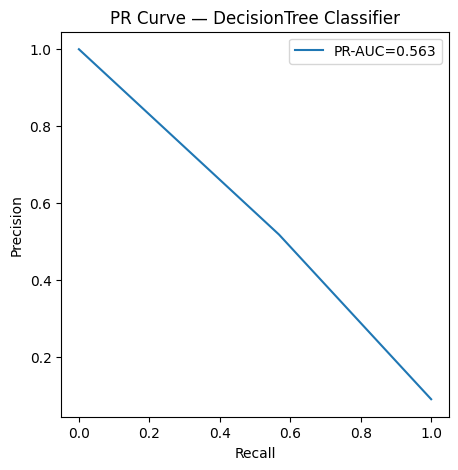

Completed: DecisionTree Classifier
Training: RandomForestClassifier()


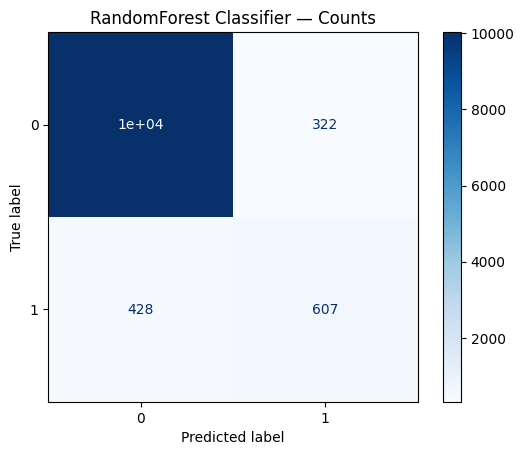

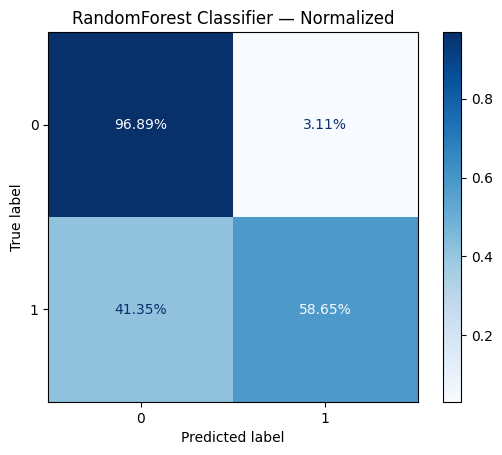

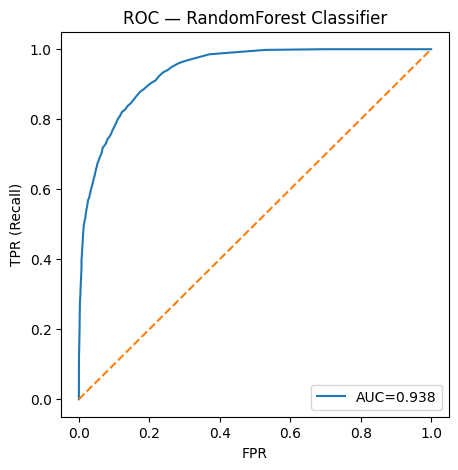

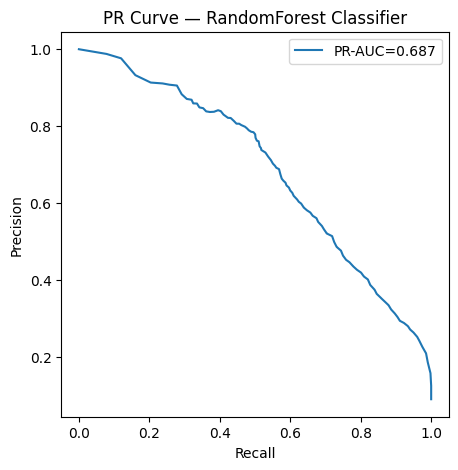

Completed: RandomForest Classifier
Training: GradientBoostingClassifier()


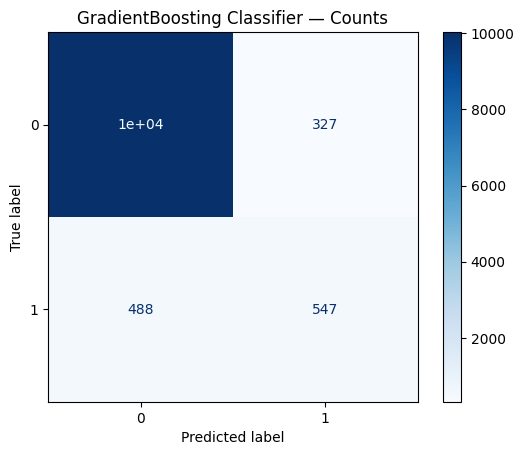

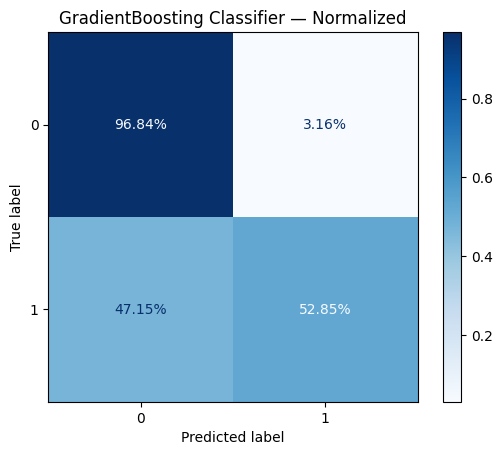

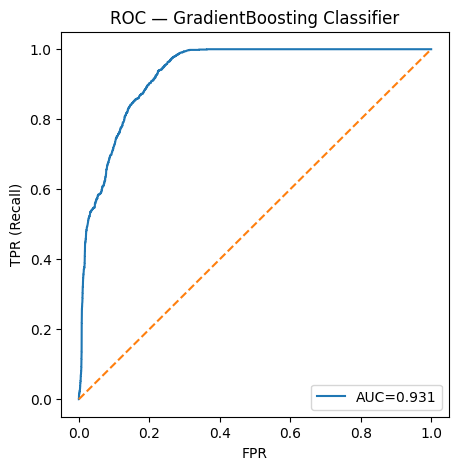

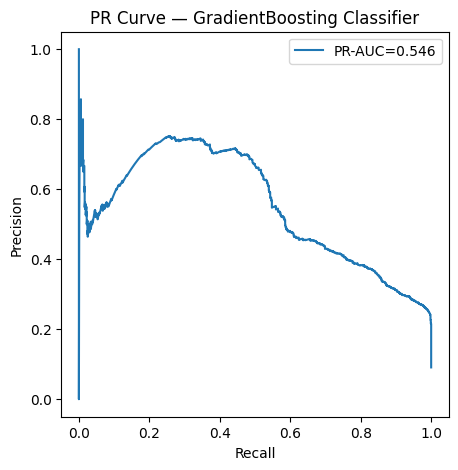

Completed: GradientBoosting Classifier
Training: BaggingClassifier()


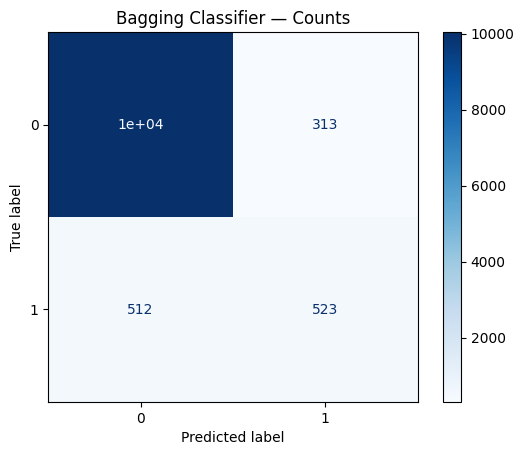

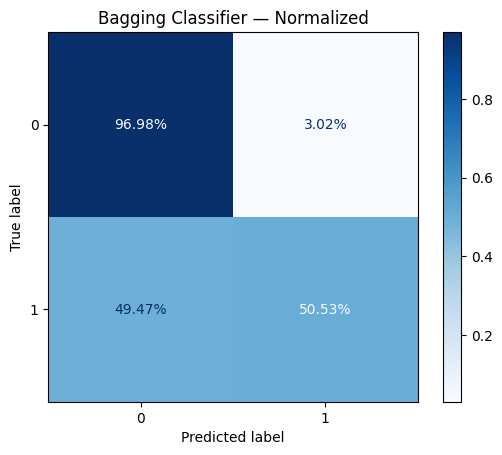

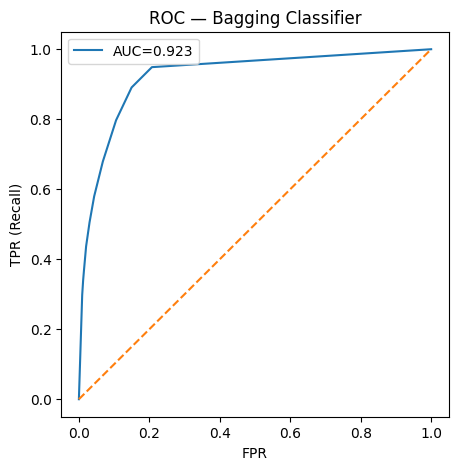

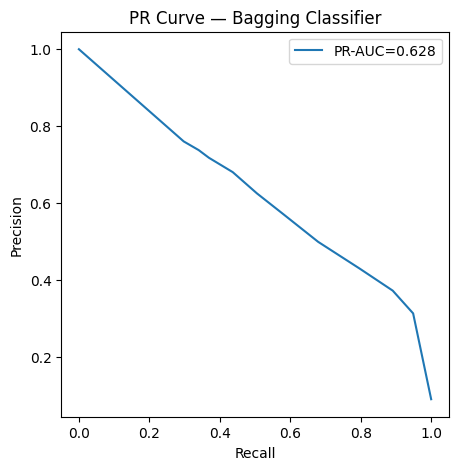

Completed: Bagging Classifier
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


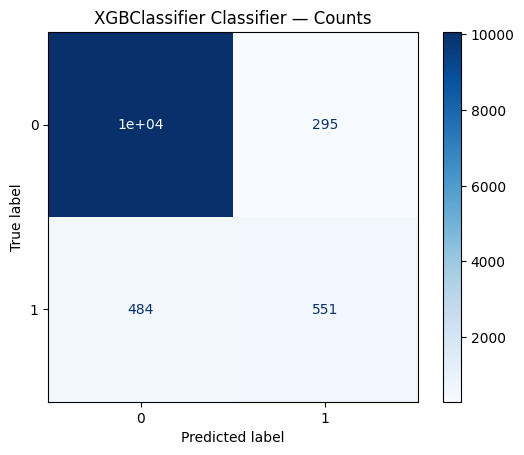

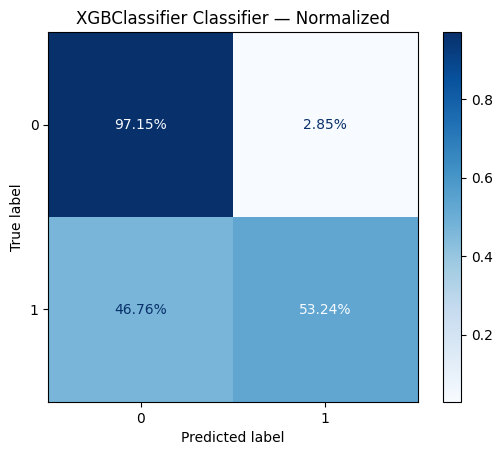

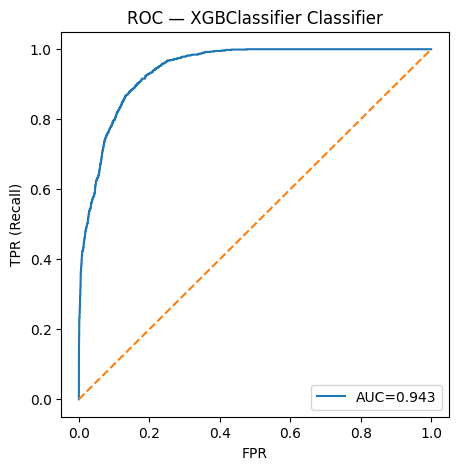

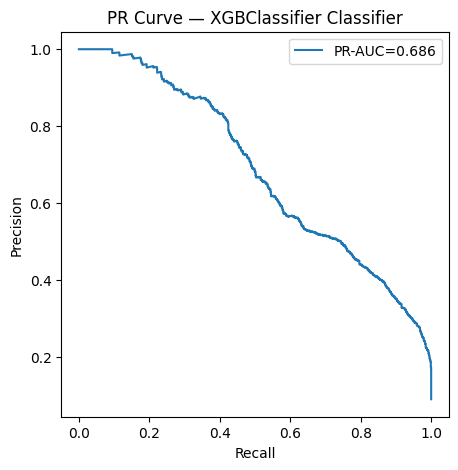

Completed: XGBClassifier Classifier
Training: AdaBoostClassifier()


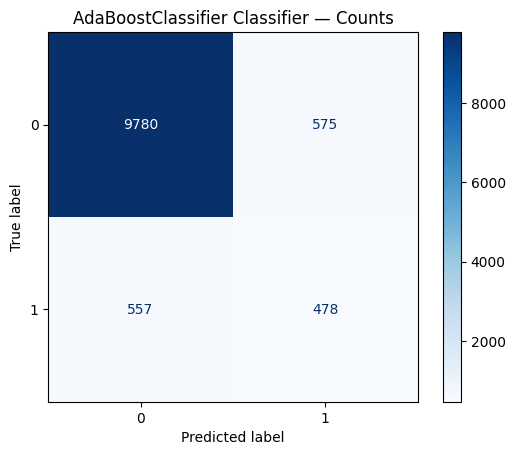

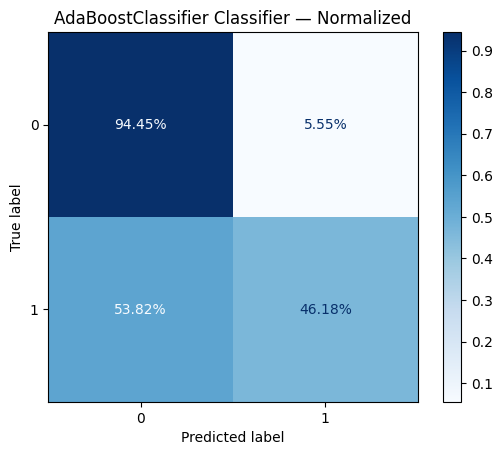

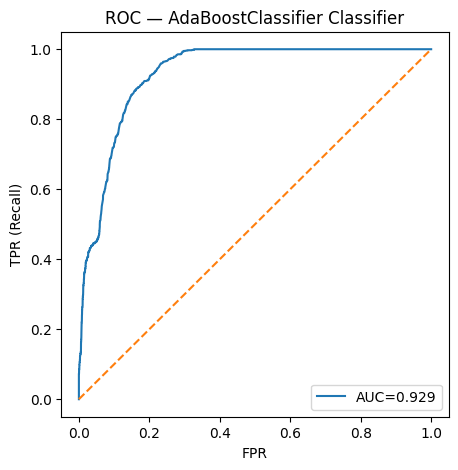

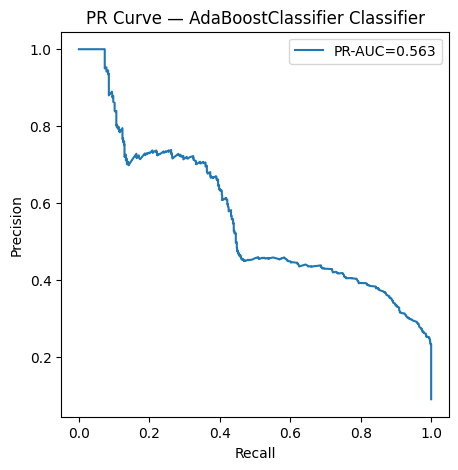

Completed: AdaBoostClassifier Classifier
Training: <catboost.core.CatBoostClassifier object at 0x000001AF8B6BA530>


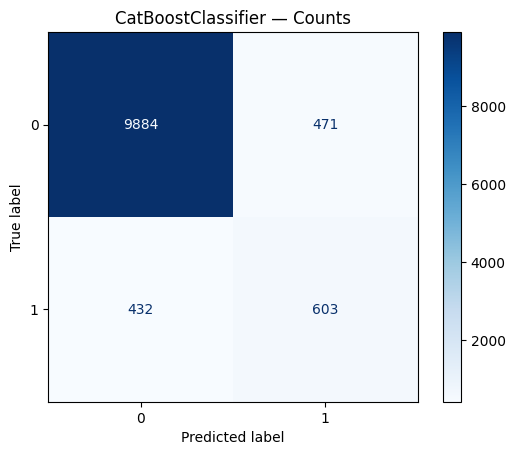

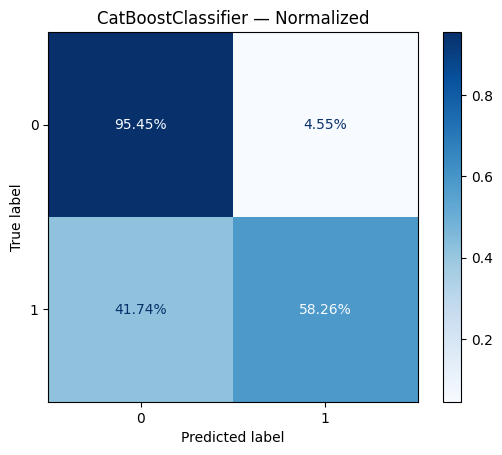

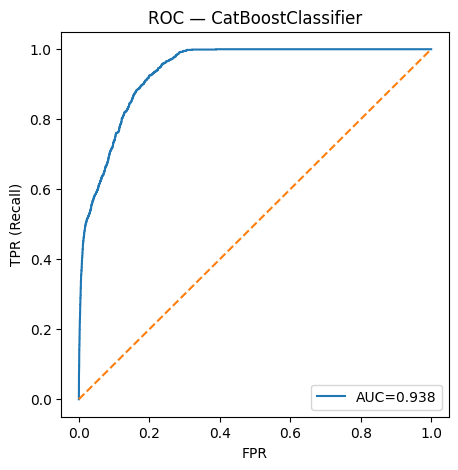

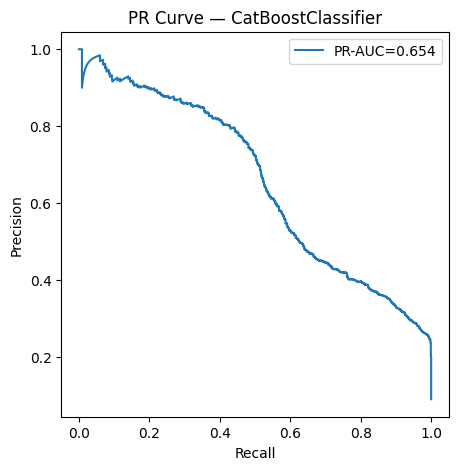

Completed: CatBoostClassifier
Training: LGBMClassifier()
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4142, number of negative: 41415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090919 -> initscore=-2.302464
[LightGBM] [Info] Start training from score -2.302464


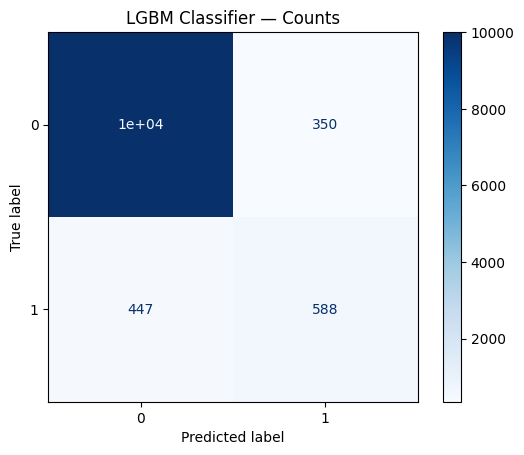

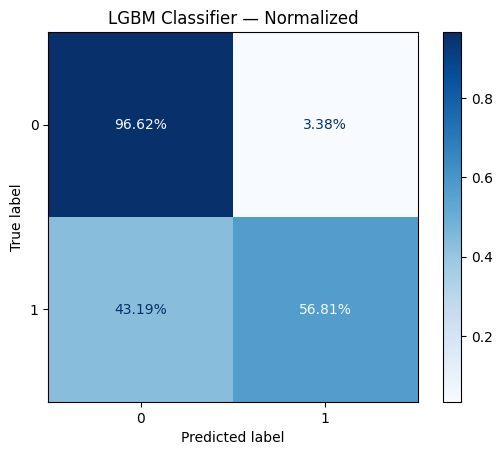

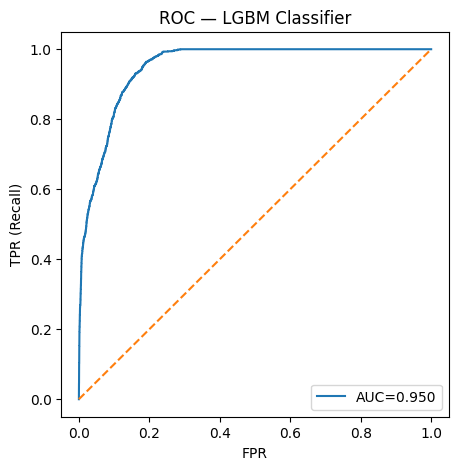

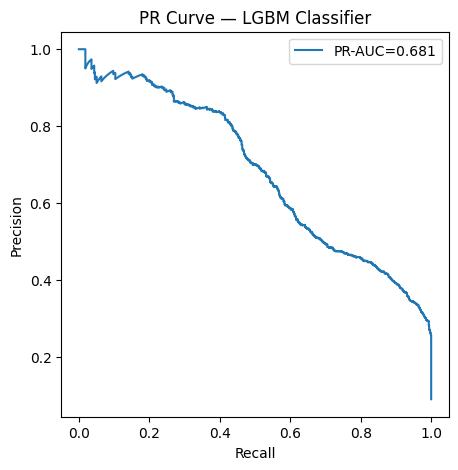

Completed: LGBM Classifier
Training: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())


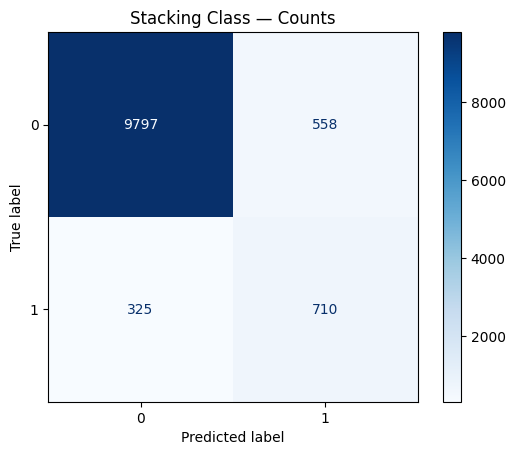

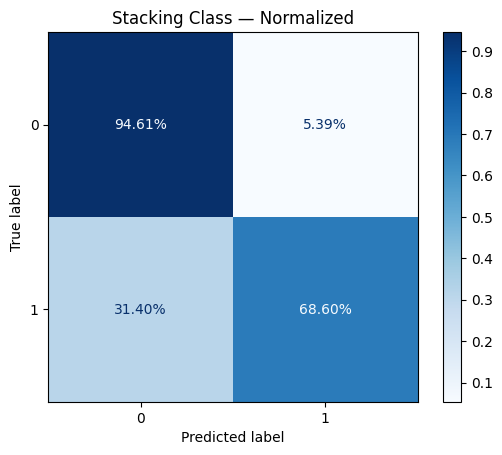

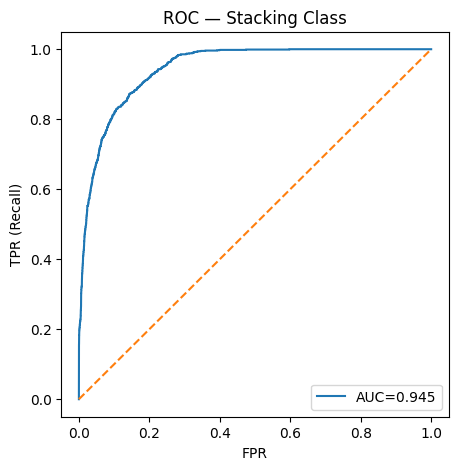

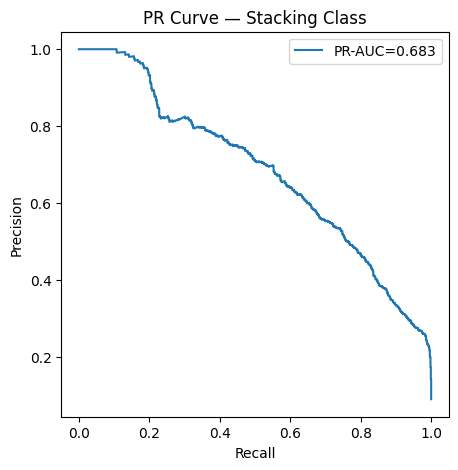

Completed: Stacking Class


Sampling                                         model_name   TP  \
0   Undersampling                               LogisticRegression()   28   
1   Undersampling                                       GaussianNB()    1   
2   Undersampling                           DecisionTreeClassifier()  588   
3   Undersampling                           RandomForestClassifier()  607   
4   Undersampling                       GradientBoostingClassifier()  547   
5   Undersampling                                BaggingClassifier()  523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...  551   
7   Undersampling                               AdaBoostClassifier()  478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...  603   
9   Undersampling                                   LGBMClassifier()  588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...  710   

     FP     TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0     1  10354  1007     0.03     0.00     1.00     0.97      0.91   
1     9  10346  1034     0.00     0.00     1.00     1.00      0.91   
2   546   9809   447     0.57     0.05     0.95     0.43      0.91   
3   322  10033   428     0.59     0.03     0.97     0.41      0.93   
4   327  10028   488     0.53     0.03     0.97     0.47      0.93   
5   313  10042   512     0.51     0.03     0.97     0.49      0.93   
6   295  10060   484     0.53     0.03     0.97     0.47      0.93   
7   575   9780   557     0.46     0.06     0.94     0.54      0.90   
8   471   9884   432     0.58     0.05     0.95     0.42      0.92   
9   350  10005   447     0.57     0.03     0.97     0.43      0.93   
10  558   9797   325     0.69     0.05     0.95     0.31      0.92   

    balanced_accuracy  recall  precision   f1  f0.5  f2.0  roc_auc  pr_auc  
0                0.51    0.03       0.97 0.05  0.12  0.03     0.79    0.34  
1                0.50    0.00       0.10 0.00  0.00  0.00     0.70    0.27  
2                0.76    0.57       0.52 0.54  0.53  0.56     0.76    0.56  
3                0.78    0.59       0.65 0.62  0.64  0.60     0.94    0.69  
4                0.75    0.53       0.63 0.57  0.60  0.55     0.93    0.55  
5                0.74    0.51       0.63 0.56  0.60  0.53     0.92    0.63  
6                0.75    0.53       0.65 0.59  0.62  0.55     0.94    0.69  
7                0.70    0.46       0.45 0.46  0.46  0.46     0.93    0.56  
8                0.77    0.58       0.56 0.57  0.57  0.58     0.94    0.65  
9                0.77    0.57       0.63 0.60  0.61  0.58     0.95    0.68  
10               0.82    0.69       0.56 0.62  0.58  0.66     0.94    0.68

In [23]:
models, names = get_models()
for i in range(len(models)):
  evaluate("Undersampling", names[i], models[i],X_train1, y_train1, X_test1,y_test1)
display_report()


In [18]:
report

Sampling                                         model_name   TP    FP  \
0     None                               LogisticRegression()    0     0   
1     None                                       GaussianNB()    0   223   
2     None                           DecisionTreeClassifier()  217  2280   
3     None                           RandomForestClassifier()  139    25   
4     None                       GradientBoostingClassifier()  119    88   
5     None                                BaggingClassifier()  150   229   
6     None  XGBClassifier(base_score=None, booster=None, c...  132   458   
7     None                               AdaBoostClassifier()   60    43   
8     None  <catboost.core.CatBoostClassifier object at 0x...  167   120   
9     None                                   LGBMClassifier()   96  1155   

        TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0  1014634  1035     0.00     0.00     1.00     1.00      1.00   
1  1014411  1035     0.00     0.00     1.00     1.00      1.00   
2  1012354   818     0.21     0.00     1.00     0.79      1.00   
3  1014609   896     0.13     0.00     1.00     0.87      1.00   
4  1014546   916     0.11     0.00     1.00     0.89      1.00   
5  1014405   885     0.14     0.00     1.00     0.86      1.00   
6  1014176   903     0.13     0.00     1.00     0.87      1.00   
7  1014591   975     0.06     0.00     1.00     0.94      1.00   
8  1014514   868     0.16     0.00     1.00     0.84      1.00   
9  1013479   939     0.09     0.00     1.00     0.91      1.00   

   balanced_accuracy  recall  precision   f1  f0.5  f2.0  roc_auc  pr_auc  
0               0.50    0.00       0.00 0.00  0.00  0.00     0.88    0.05  
1               0.50    0.00       0.00 0.00  0.00  0.00     0.66    0.02  
2               0.60    0.21       0.09 0.12  0.10  0.16     0.60    0.15  
3               0.57    0.13       0.85 0.23  0.41  0.16     0.85    0.23  
4               0.56    0.11       0.57 0.19  0.32  0.14     0.96    0.13  
5               0.57    0.14       0.40 0.21  0.29  0.17     0.71    0.15  
6               0.56    0.13       0.22 0.16  0.19  0.14     0.88    0.08  
7               0.53    0.06       0.58 0.11  0.21  0.07     0.97    0.10  
8               0.58    0.16       0.58 0.25  0.38  0.19     0.97    0.22  
9               0.55    0.09       0.08 0.08  0.08  0.09     0.85    0.06

In [19]:
import joblib
from joblib import dump

dump((report), 'original_data_results.joblib')

['original_data_results.joblib']

In [2]:
import joblib
from joblib import load

df_original = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\notebooks\original_data_results.joblib')

In [3]:
df_original

Sampling                                         model_name   TP    FP  \
0     None                               LogisticRegression()    0     0   
1     None                                       GaussianNB()    0   223   
2     None                           DecisionTreeClassifier()  217  2280   
3     None                           RandomForestClassifier()  139    25   
4     None                       GradientBoostingClassifier()  119    88   
5     None                                BaggingClassifier()  150   229   
6     None  XGBClassifier(base_score=None, booster=None, c...  132   458   
7     None                               AdaBoostClassifier()   60    43   
8     None  <catboost.core.CatBoostClassifier object at 0x...  167   120   
9     None                                   LGBMClassifier()   96  1155   

        TN    FN   TP_rate   FP_rate   TN_rate   FN_rate  accuracy  \
0  1014634  1035  0.000000  0.000000  1.000000  1.000000  0.998981   
1  1014411  1035  0.000000  0.000220  0.999780  1.000000  0.998761   
2  1012354   818  0.209662  0.002247  0.997753  0.790338  0.996950   
3  1014609   896  0.134300  0.000025  0.999975  0.865700  0.999093   
4  1014546   916  0.114976  0.000087  0.999913  0.885024  0.999011   
5  1014405   885  0.144928  0.000226  0.999774  0.855072  0.998903   
6  1014176   903  0.127536  0.000451  0.999549  0.872464  0.998660   
7  1014591   975  0.057971  0.000042  0.999958  0.942029  0.998998   
8  1014514   868  0.161353  0.000118  0.999882  0.838647  0.999027   
9  1013479   939  0.092754  0.001138  0.998862  0.907246  0.997938   

   balanced_accuracy    recall  precision        f1      f0.5      f2.0  \
0           0.500000  0.000000   0.000000  0.000000  0.000000  0.000000   
1           0.499890  0.000000   0.000000  0.000000  0.000000  0.000000   
2           0.603707  0.209662   0.086904  0.122877  0.098431  0.163477   
3           0.567137  0.134300   0.847561  0.231860  0.410999  0.161478   
4           0.557445  0.114976   0.574879  0.191626  0.319377  0.136876   
5           0.572351  0.144928   0.395778  0.212164  0.294002  0.165966   
6           0.563542  0.127536   0.223729  0.162462  0.194404  0.139535   
7           0.528964  0.057971   0.582524  0.105448  0.207326  0.070705   
8           0.580617  0.161353   0.581882  0.252648  0.382501  0.188615   
9           0.545808  0.092754   0.076739  0.083990  0.079483  0.089037   

    roc_auc    pr_auc  
0  0.879586  0.047298  
1  0.663414  0.015217  
2  0.603707  0.148686  
3  0.847890  0.232293  
4  0.955232  0.133080  
5  0.708635  0.153298  
6  0.881090  0.076759  
7  0.965480  0.102951  
8  0.967108  0.215975  
9  0.853517  0.064745

### Using smote modified datasets

In [24]:
X_train2, y_train2, X_test2, y_test2 = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\notebooks\SMOTE_dataset_splits.joblib')

Training: LogisticRegression()


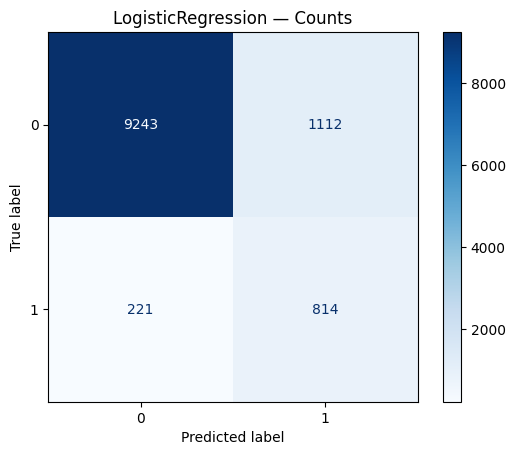

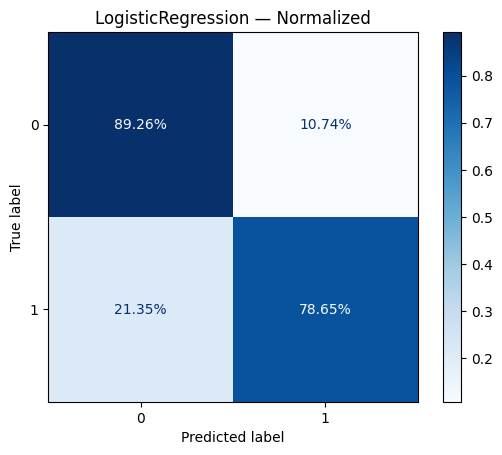

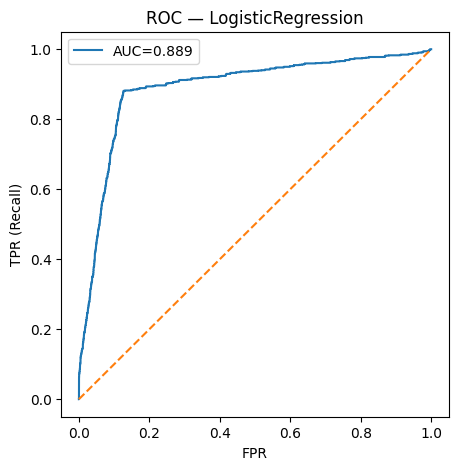

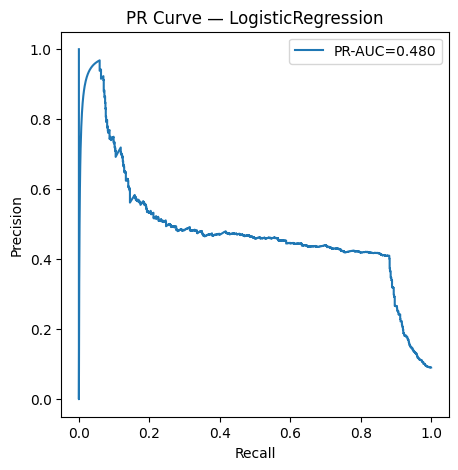

Completed: LogisticRegression
Training: GaussianNB()


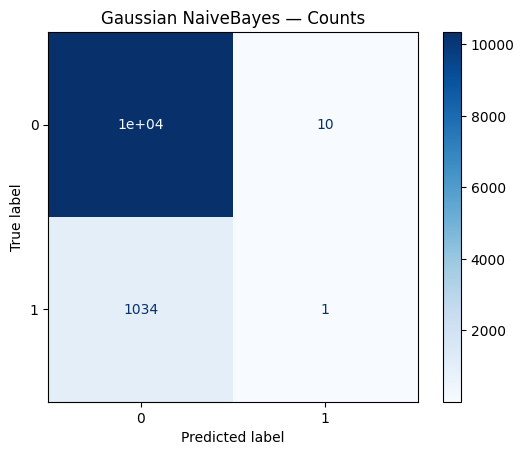

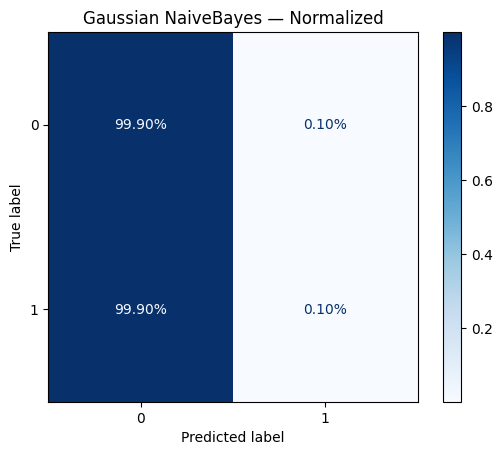

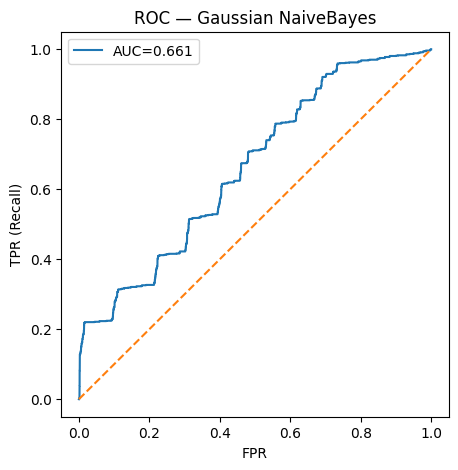

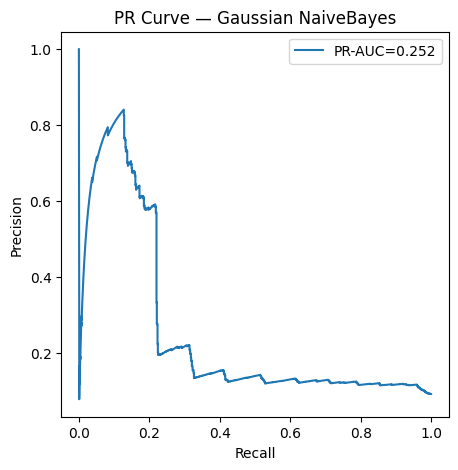

Completed: Gaussian NaiveBayes
Training: DecisionTreeClassifier()


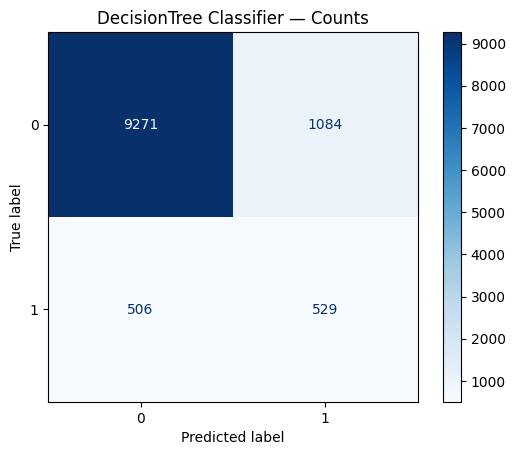

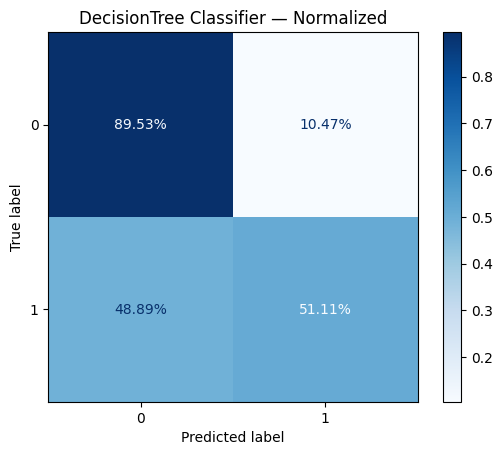

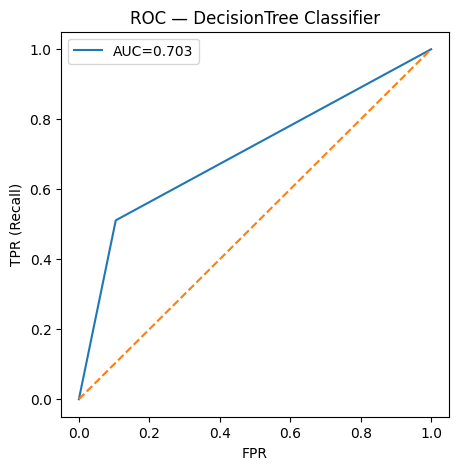

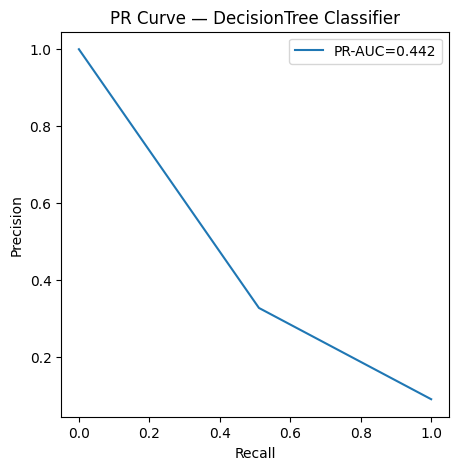

Completed: DecisionTree Classifier
Training: RandomForestClassifier()


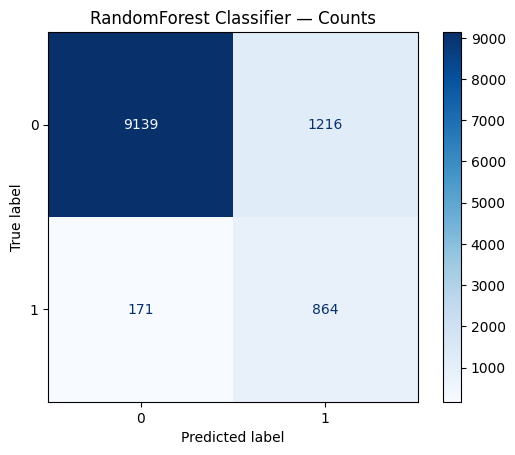

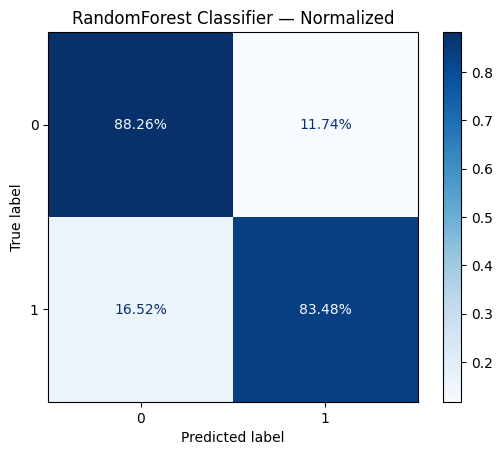

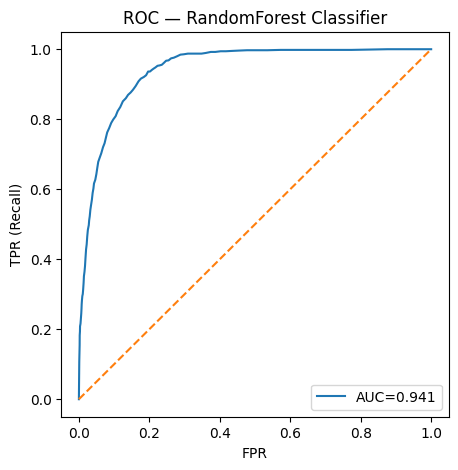

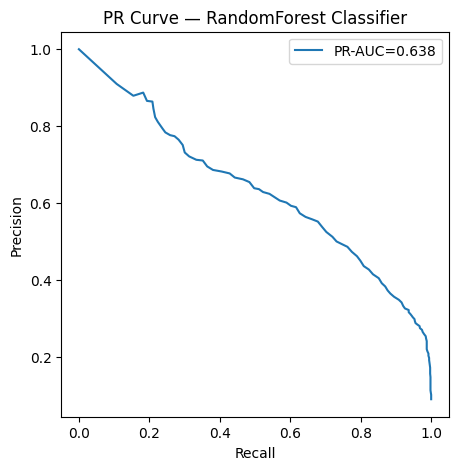

Completed: RandomForest Classifier
Training: GradientBoostingClassifier()


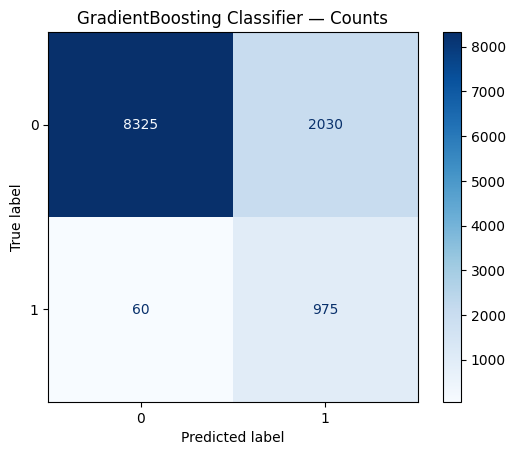

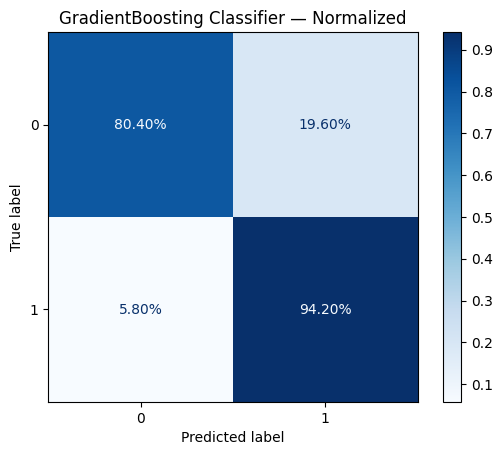

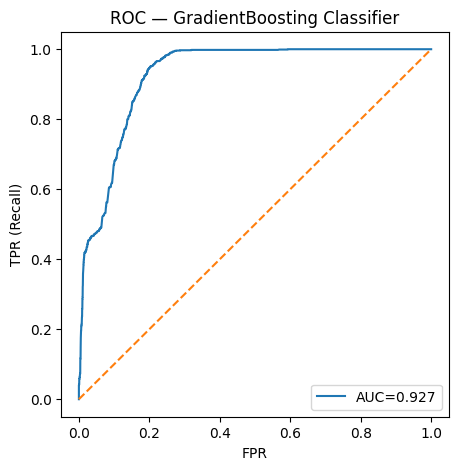

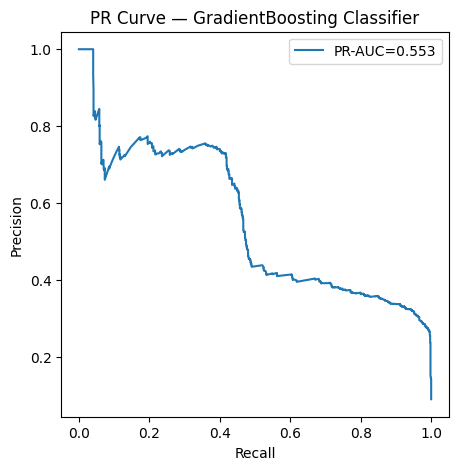

Completed: GradientBoosting Classifier
Training: BaggingClassifier()


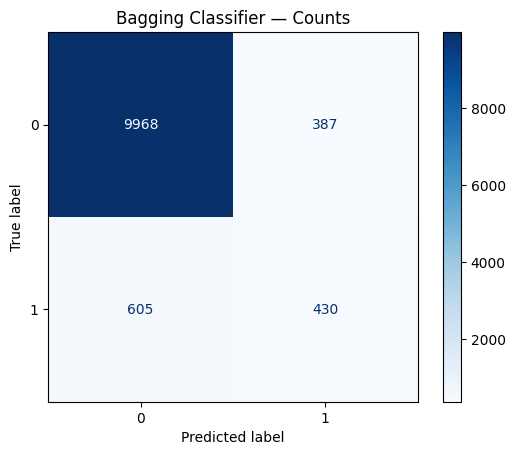

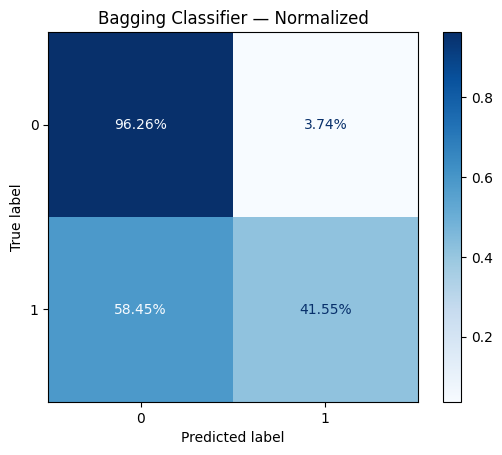

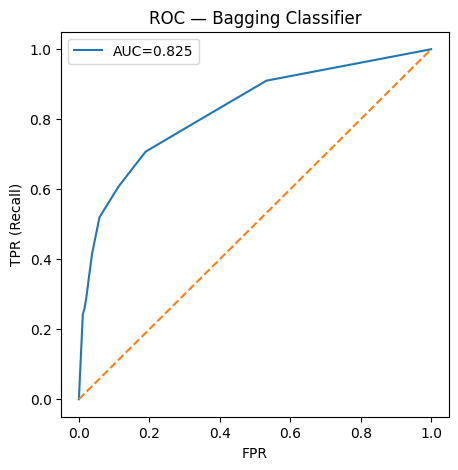

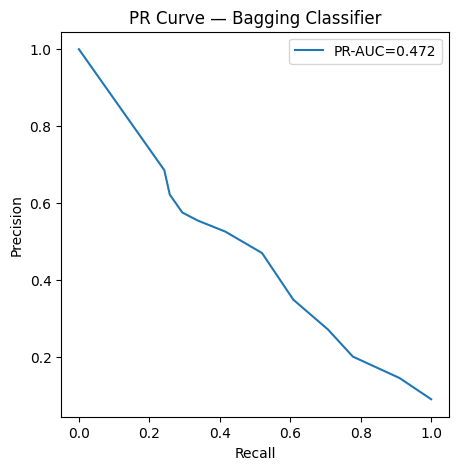

Completed: Bagging Classifier
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


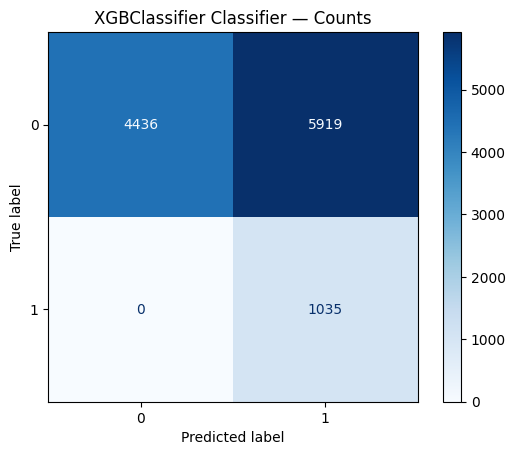

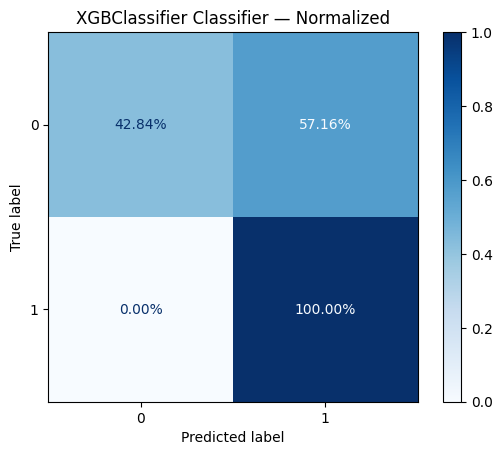

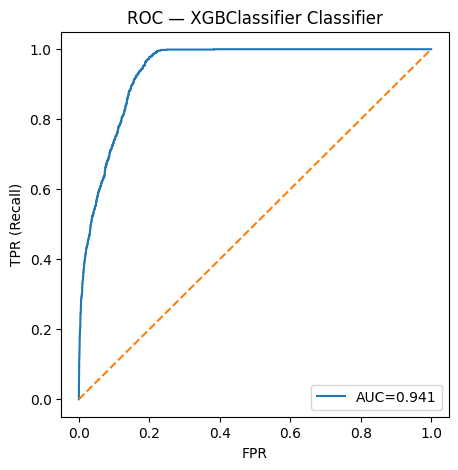

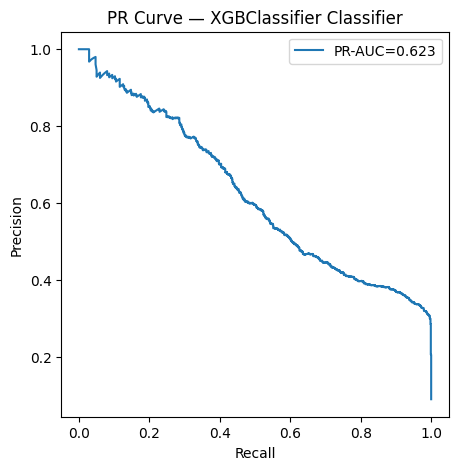

Completed: XGBClassifier Classifier
Training: AdaBoostClassifier()


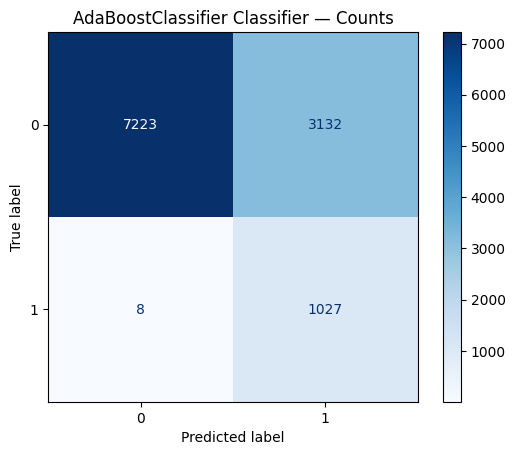

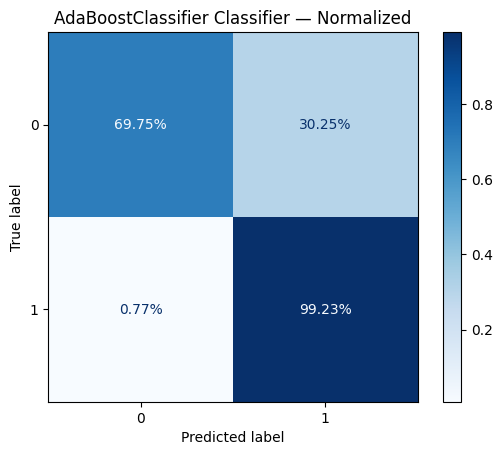

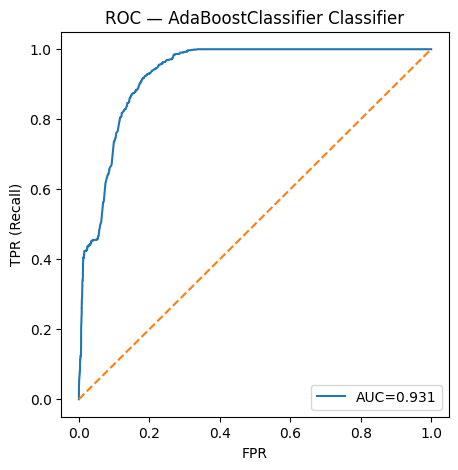

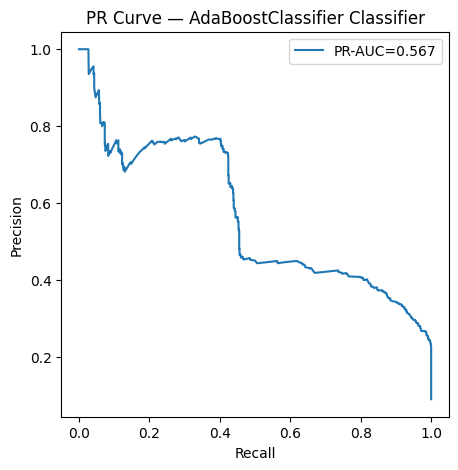

Completed: AdaBoostClassifier Classifier
Training: <catboost.core.CatBoostClassifier object at 0x000001AF943F2B60>


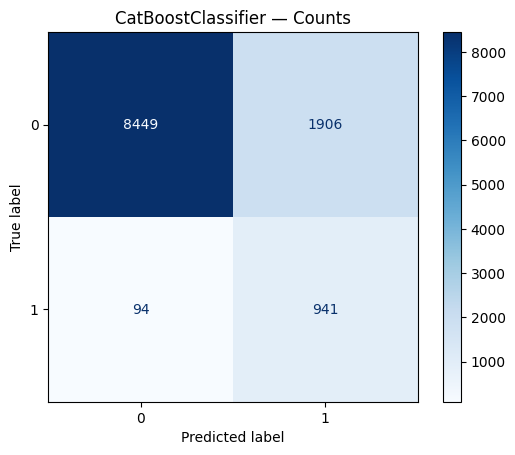

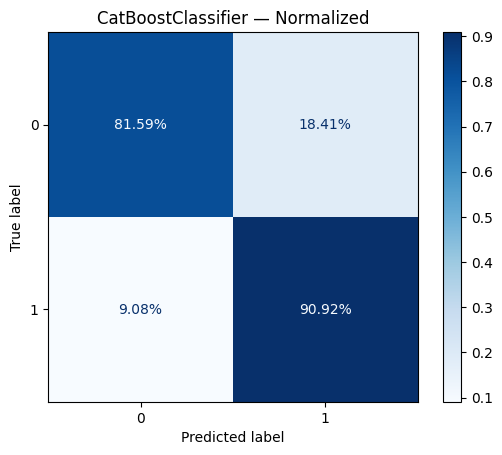

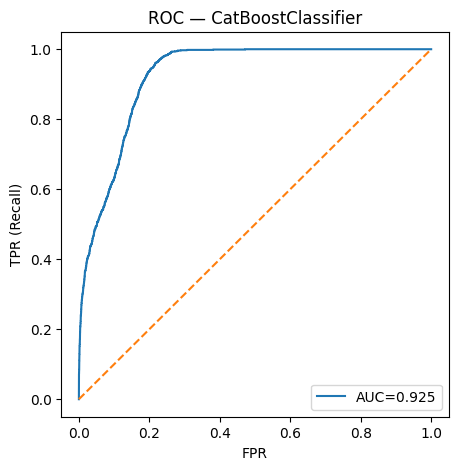

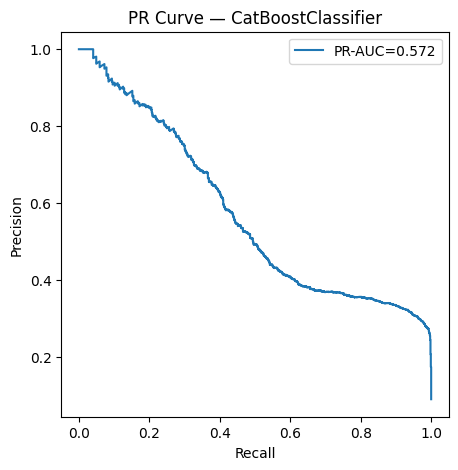

Completed: CatBoostClassifier
Training: LGBMClassifier()
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16566, number of negative: 41415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 57981, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291


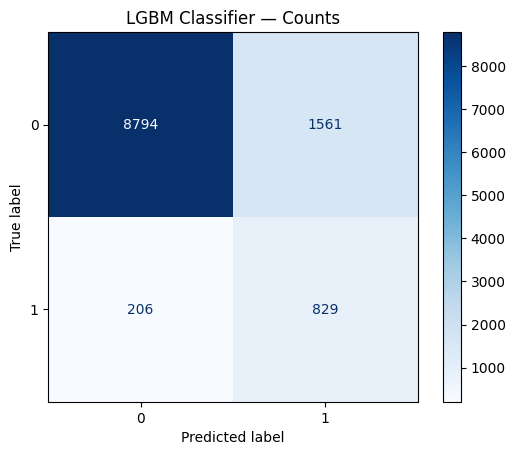

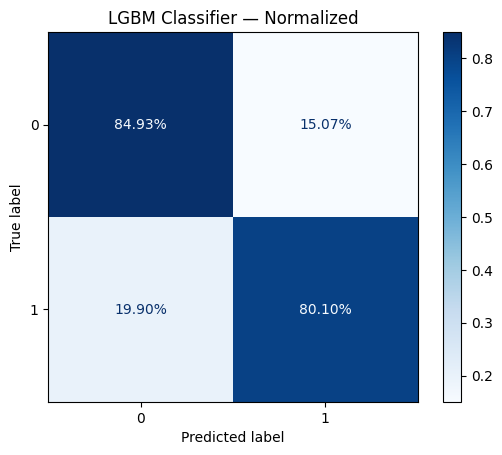

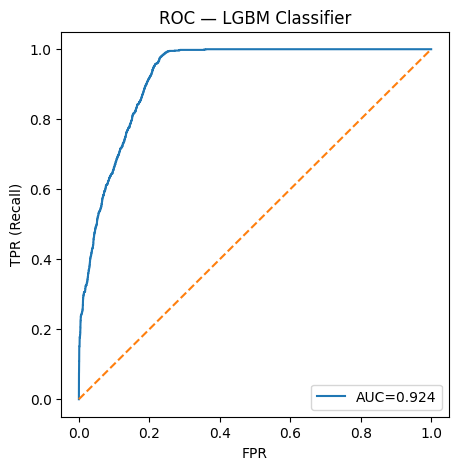

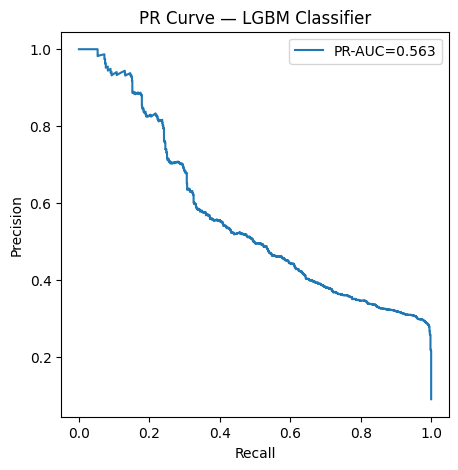

Completed: LGBM Classifier
Training: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())


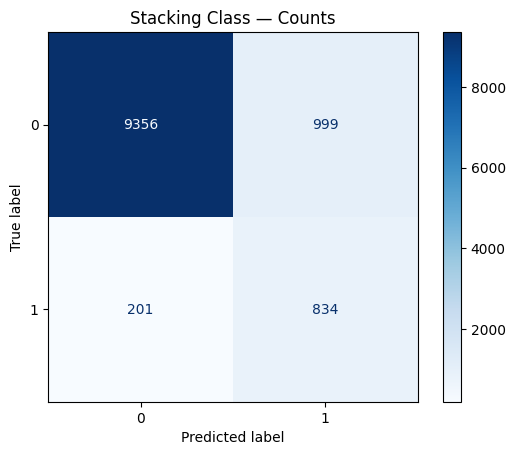

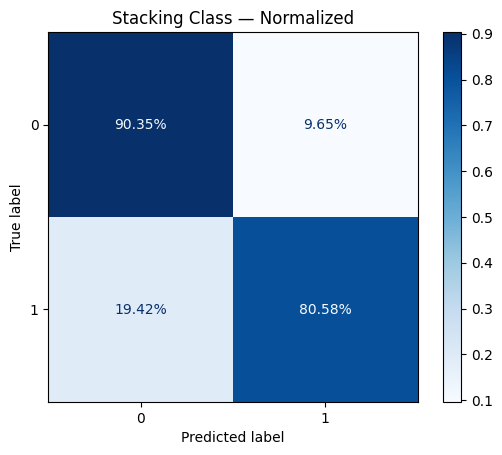

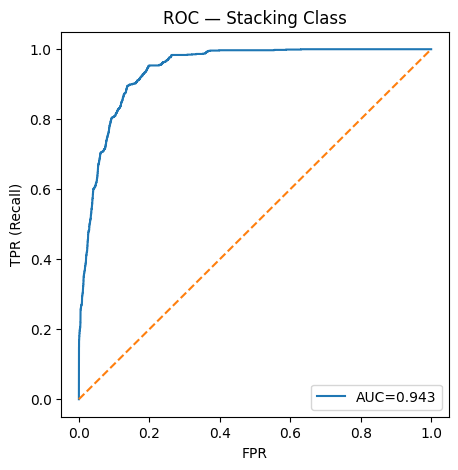

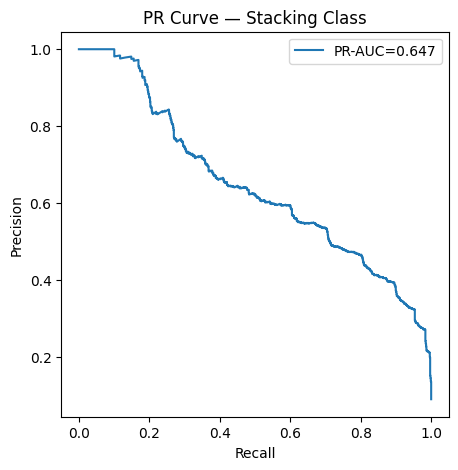

Completed: Stacking Class


Sampling                                         model_name    TP  \
0   Undersampling                               LogisticRegression()    28   
1   Undersampling                                       GaussianNB()     1   
2   Undersampling                           DecisionTreeClassifier()   588   
3   Undersampling                           RandomForestClassifier()   607   
4   Undersampling                       GradientBoostingClassifier()   547   
5   Undersampling                                BaggingClassifier()   523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
7   Undersampling                               AdaBoostClassifier()   478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
9   Undersampling                                   LGBMClassifier()   588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
11          SMOTE                               LogisticRegression()   814   
12          SMOTE                                       GaussianNB()     1   
13          SMOTE                           DecisionTreeClassifier()   529   
14          SMOTE                           RandomForestClassifier()   864   
15          SMOTE                       GradientBoostingClassifier()   975   
16          SMOTE                                BaggingClassifier()   430   
17          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
18          SMOTE                               AdaBoostClassifier()  1027   
19          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
20          SMOTE                                   LGBMClassifier()   829   
21          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   

      FP     TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0      1  10354  1007     0.03     0.00     1.00     0.97      0.91   
1      9  10346  1034     0.00     0.00     1.00     1.00      0.91   
2    546   9809   447     0.57     0.05     0.95     0.43      0.91   
3    322  10033   428     0.59     0.03     0.97     0.41      0.93   
4    327  10028   488     0.53     0.03     0.97     0.47      0.93   
5    313  10042   512     0.51     0.03     0.97     0.49      0.93   
6    295  10060   484     0.53     0.03     0.97     0.47      0.93   
7    575   9780   557     0.46     0.06     0.94     0.54      0.90   
8    471   9884   432     0.58     0.05     0.95     0.42      0.92   
9    350  10005   447     0.57     0.03     0.97     0.43      0.93   
10   558   9797   325     0.69     0.05     0.95     0.31      0.92   
11  1112   9243   221     0.79     0.11     0.89     0.21      0.88   
12    10  10345  1034     0.00     0.00     1.00     1.00      0.91   
13  1084   9271   506     0.51     0.10     0.90     0.49      0.86   
14  1216   9139   171     0.83     0.12     0.88     0.17      0.88   
15  2030   8325    60     0.94     0.20     0.80     0.06      0.82   
16   387   9968   605     0.42     0.04     0.96     0.58      0.91   
17  5919   4436     0     1.00     0.57     0.43     0.00      0.48   
18  3132   7223     8     0.99     0.30     0.70     0.01      0.72   
19  1906   8449    94     0.91     0.18     0.82     0.09      0.82   
20  1561   8794   206     0.80     0.15     0.85     0.20      0.84   
21   999   9356   201     0.81     0.10     0.90     0.19      0.89   

    balanced_accuracy  recall  precision   f1  f0.5  f2.0  roc_auc  pr_auc  
0                0.51    0.03       0.97 0.05  0.12  0.03     0.79    0.34  
1                0.50    0.00       0.10 0.00  0.00  0.00     0.70    0.27  
2                0.76    0.57       0.52 0.54  0.53  0.56     0.76    0.56  
3                0.78    0.59       0.65 0.62  0.64  0.60     0.94    0.69  
4                0.75    0.53       0.63 0.57  0.60  0.55     0.93    0.55  
5                0.74    0.51       0.63 0.56  0.60  0.53     0.92    0.63  
6                0.75    0.53       0.65 

In [25]:
models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTE", names[i], models[i],X_train2, y_train2, X_test2,y_test2)
display_report()

### Using Smoteenn

In [26]:
X_train3, y_train3, X_test3, y_test3 = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\notebooks\SMOTEENN_dataset_splits.joblib')

Training: LogisticRegression()


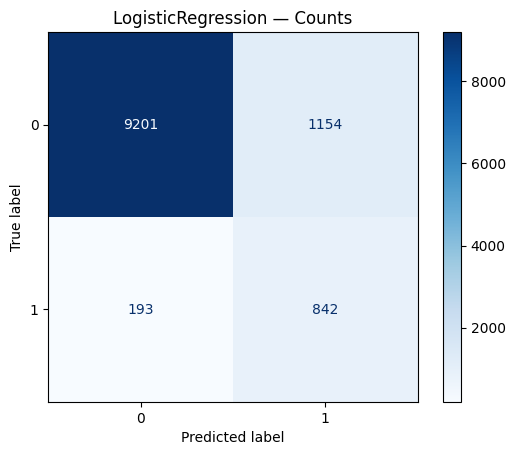

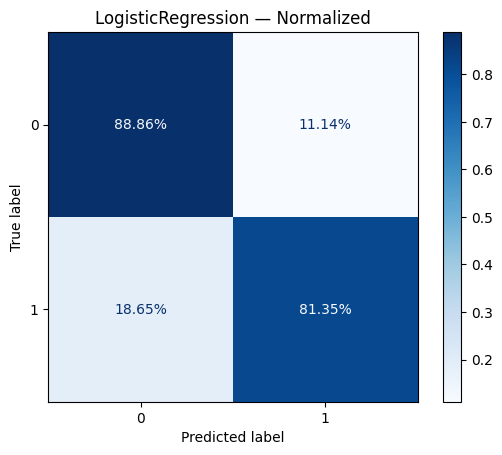

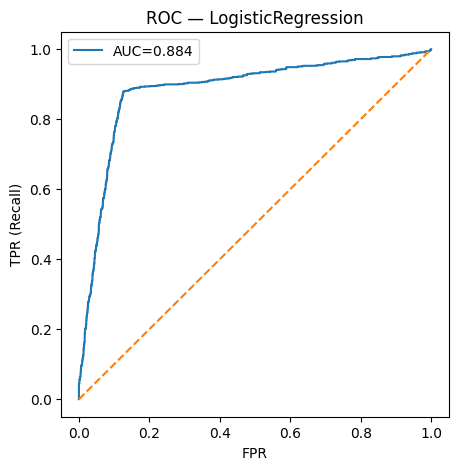

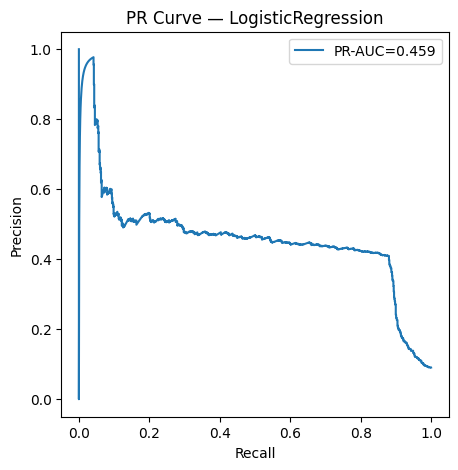

Completed: LogisticRegression
Training: GaussianNB()


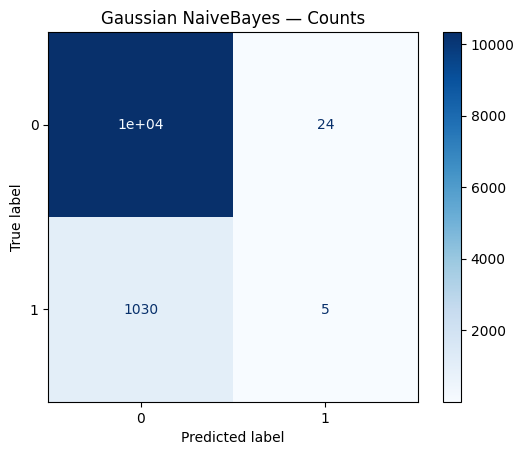

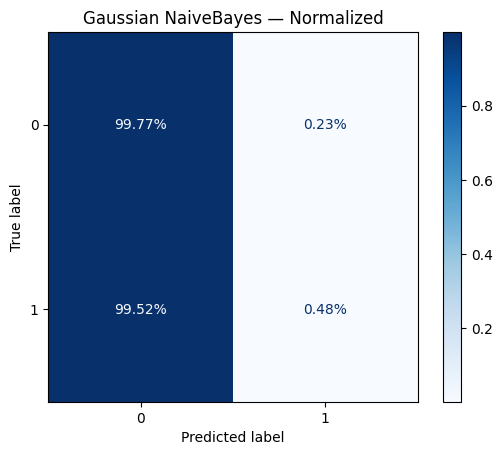

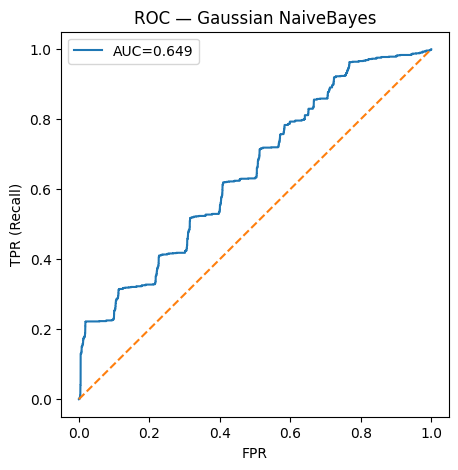

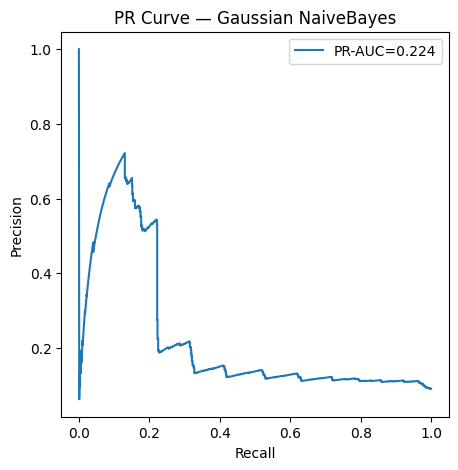

Completed: Gaussian NaiveBayes
Training: DecisionTreeClassifier()


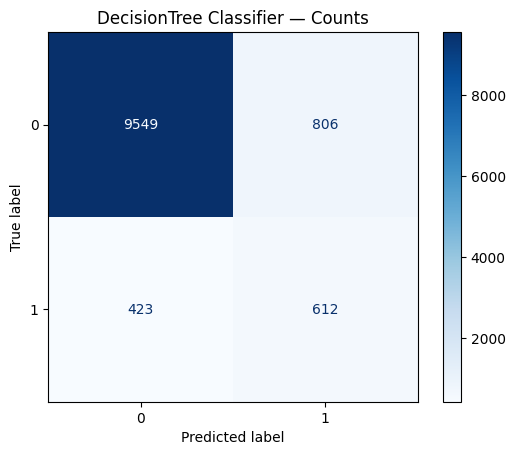

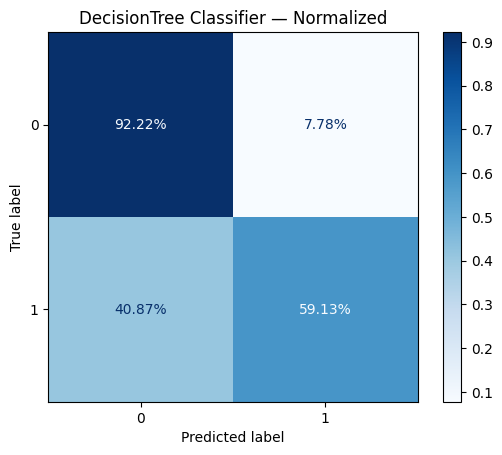

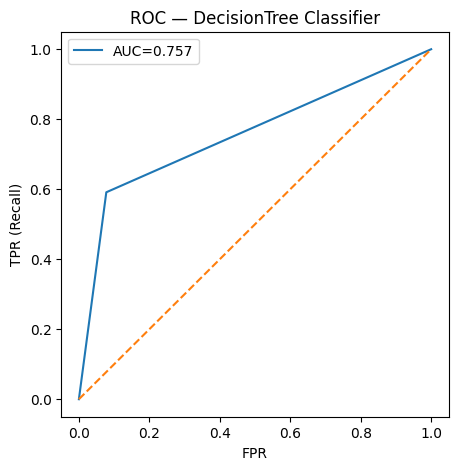

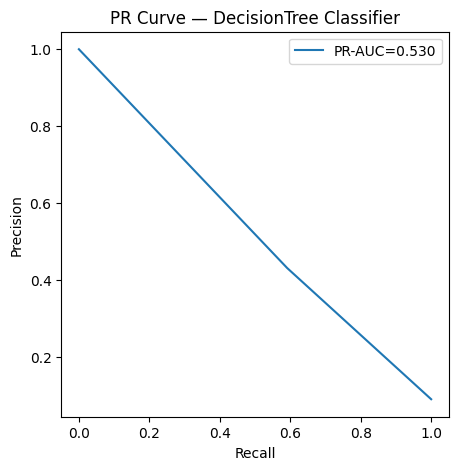

Completed: DecisionTree Classifier
Training: RandomForestClassifier()


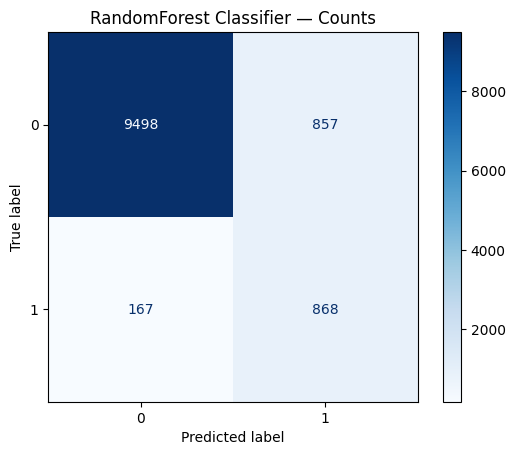

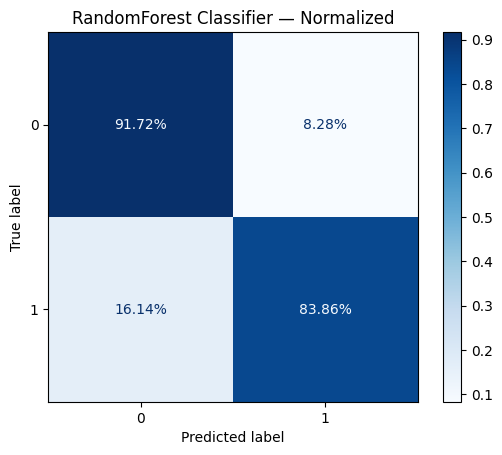

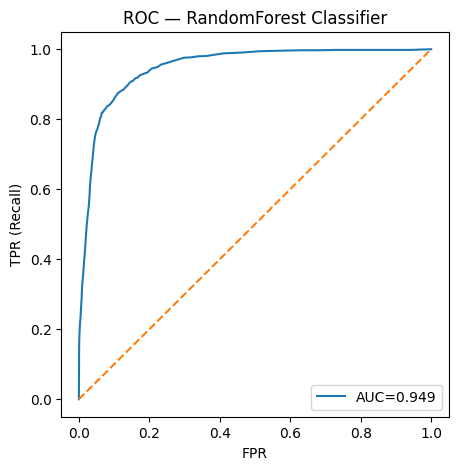

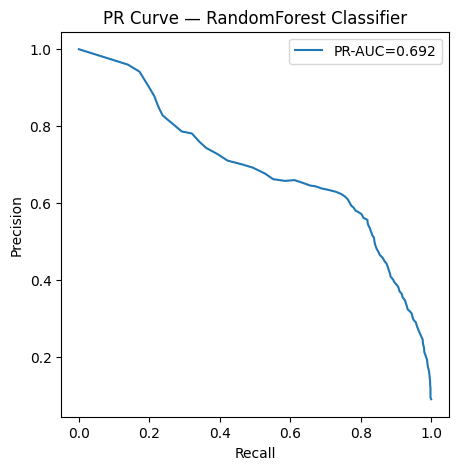

Completed: RandomForest Classifier
Training: GradientBoostingClassifier()


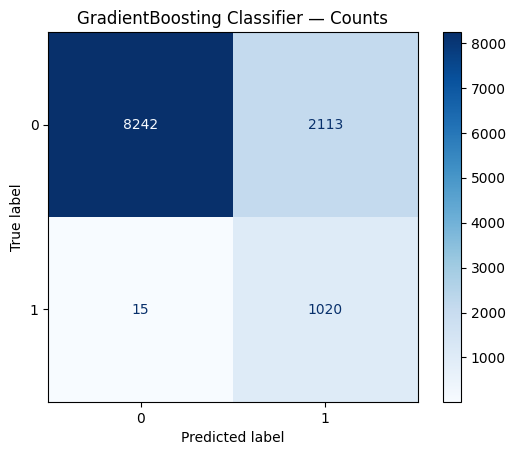

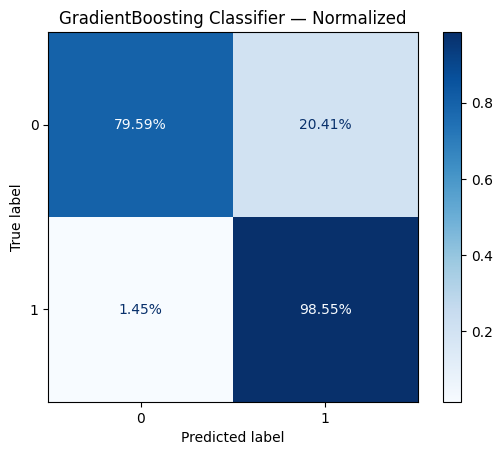

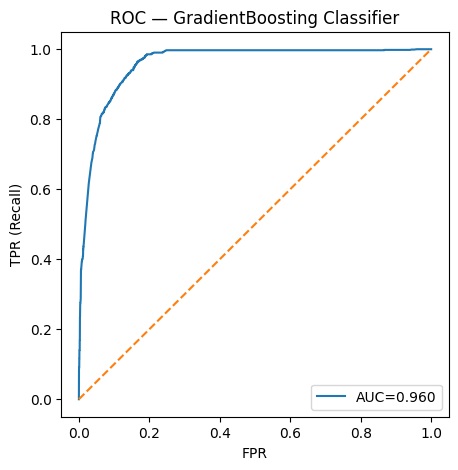

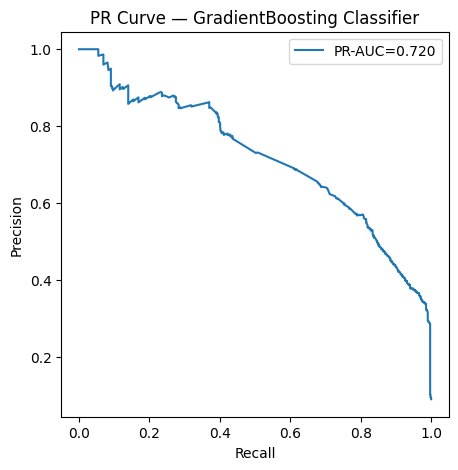

Completed: GradientBoosting Classifier
Training: BaggingClassifier()


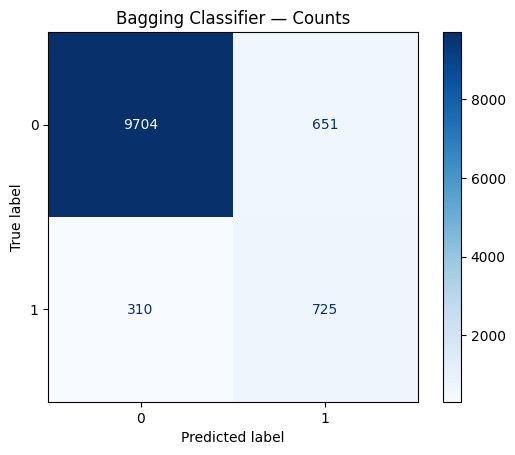

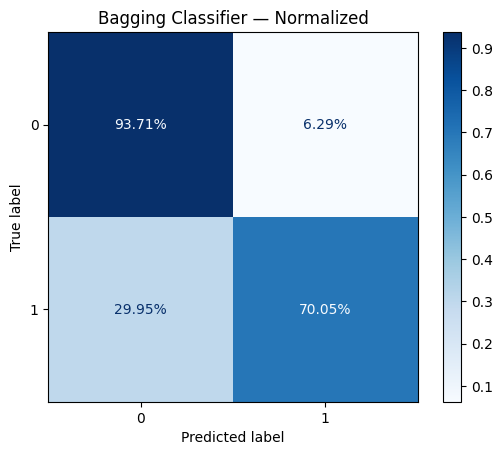

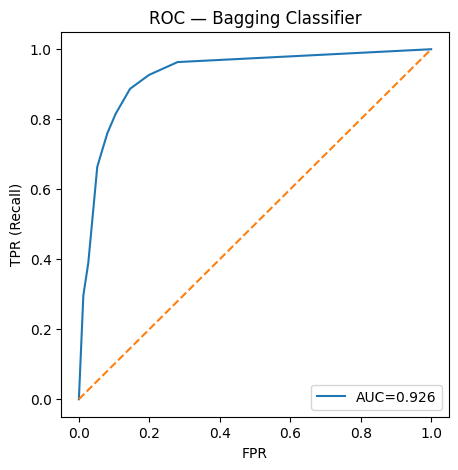

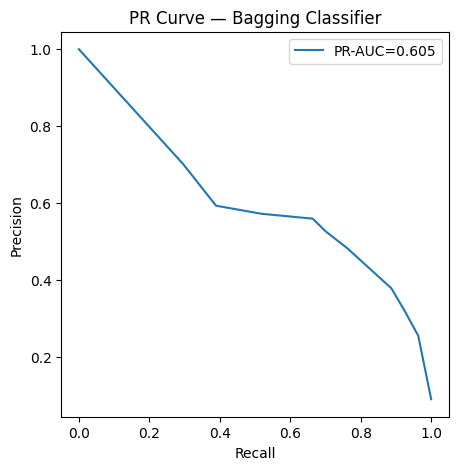

Completed: Bagging Classifier
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


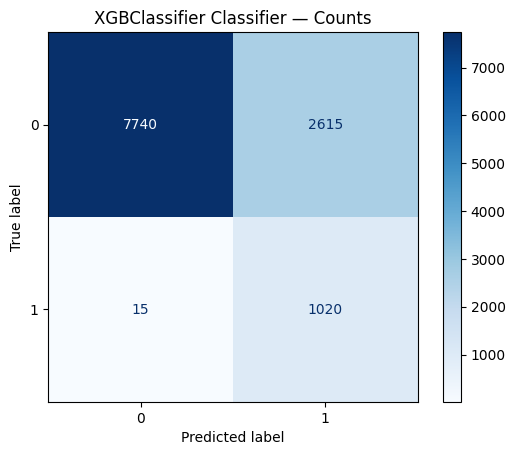

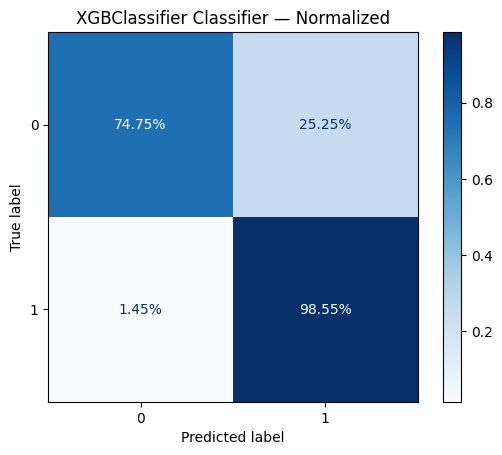

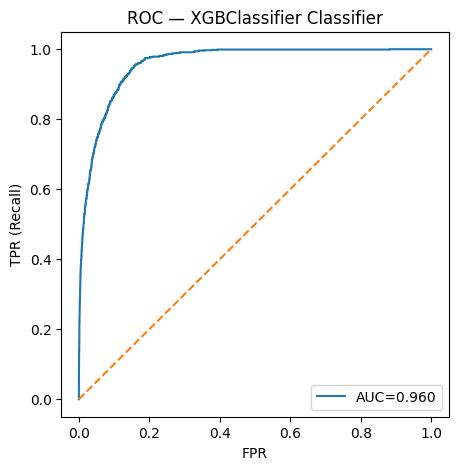

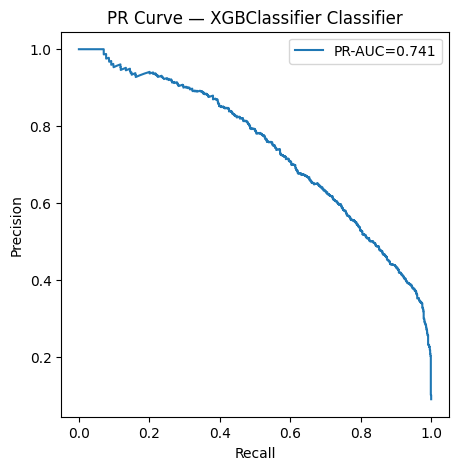

Completed: XGBClassifier Classifier
Training: AdaBoostClassifier()


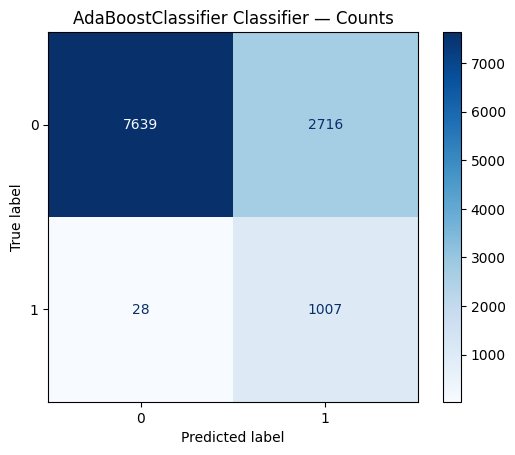

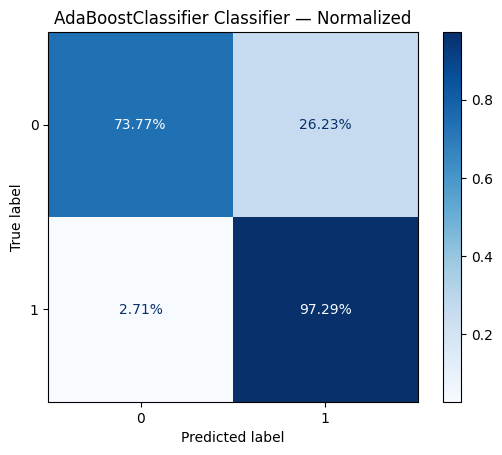

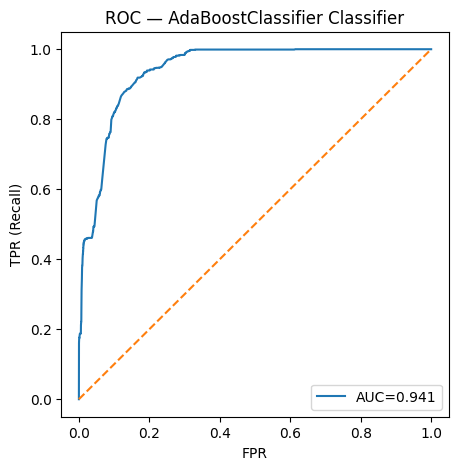

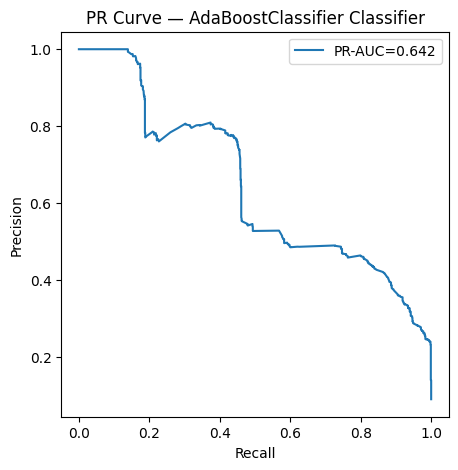

Completed: AdaBoostClassifier Classifier
Training: <catboost.core.CatBoostClassifier object at 0x000001AF971D7670>


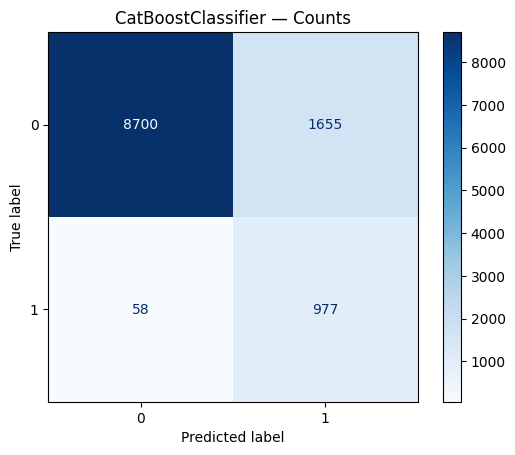

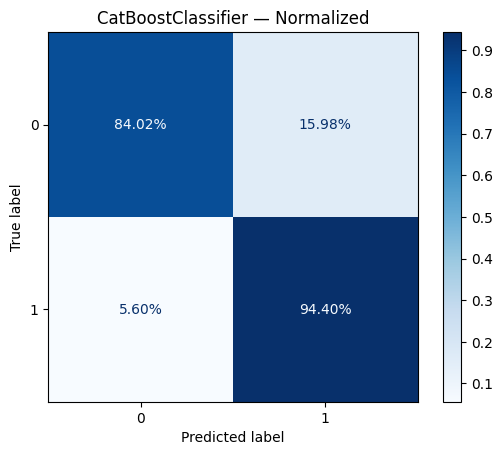

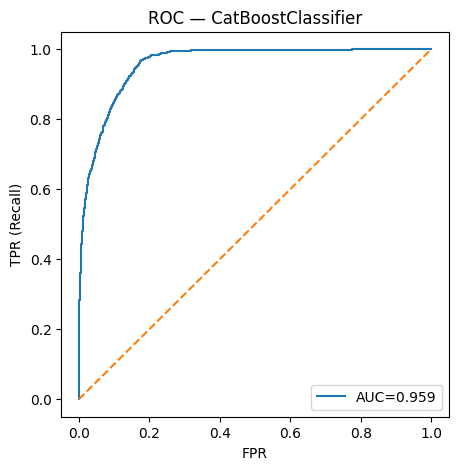

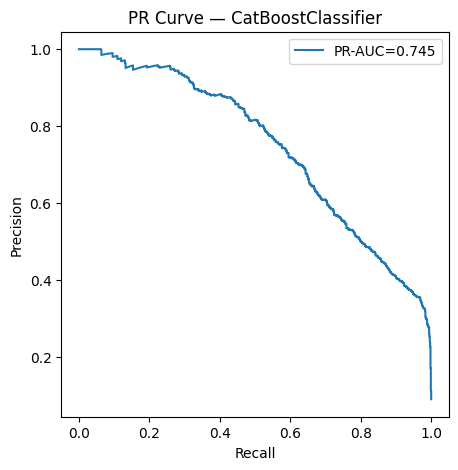

Completed: CatBoostClassifier
Training: LGBMClassifier()
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11057, number of negative: 35661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 46718, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236675 -> initscore=-1.170994
[LightGBM] [Info] Start training from score -1.170994


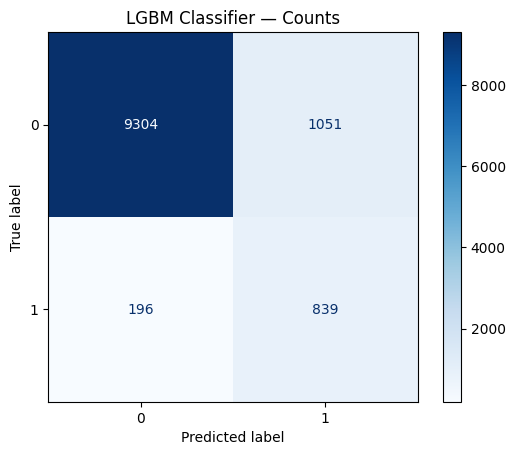

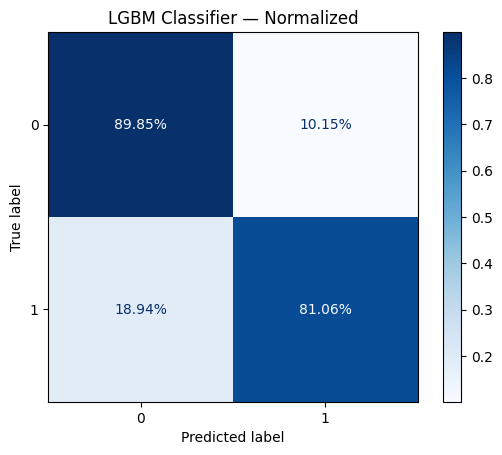

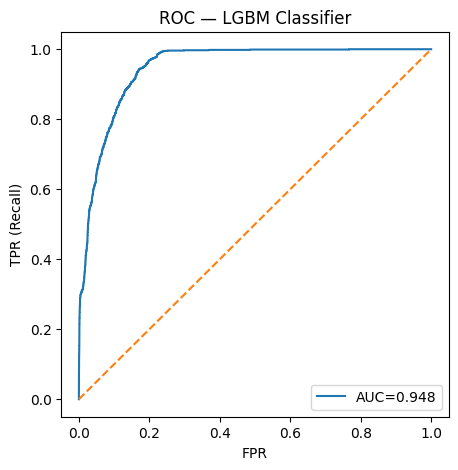

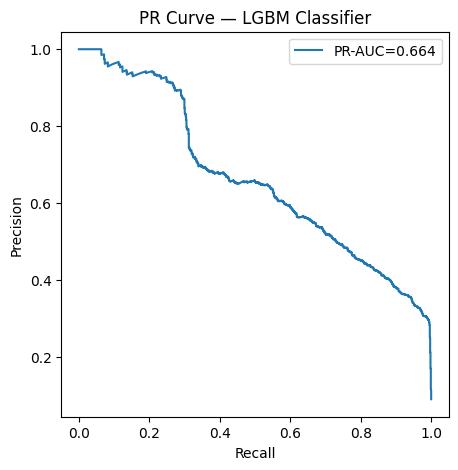

Completed: LGBM Classifier
Training: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())


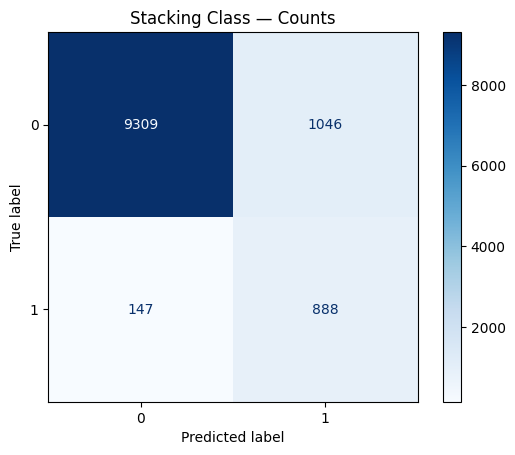

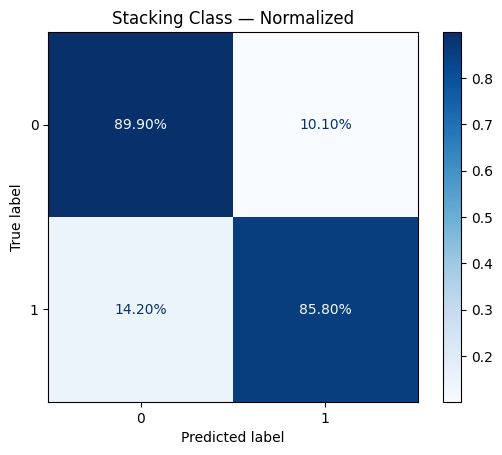

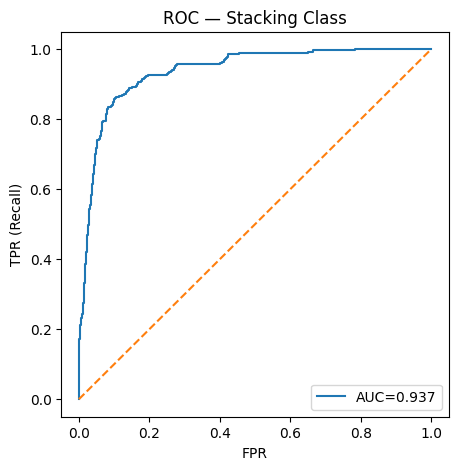

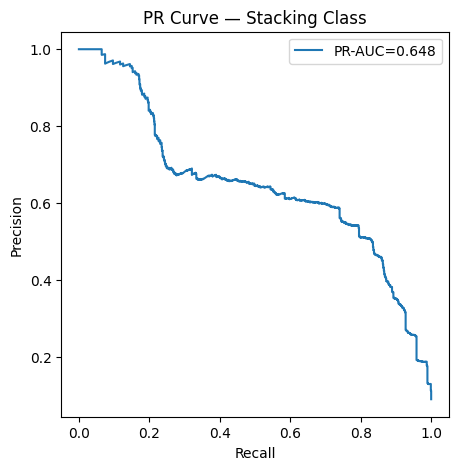

Completed: Stacking Class


Sampling                                         model_name    TP  \
0   Undersampling                               LogisticRegression()    28   
1   Undersampling                                       GaussianNB()     1   
2   Undersampling                           DecisionTreeClassifier()   588   
3   Undersampling                           RandomForestClassifier()   607   
4   Undersampling                       GradientBoostingClassifier()   547   
5   Undersampling                                BaggingClassifier()   523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
7   Undersampling                               AdaBoostClassifier()   478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
9   Undersampling                                   LGBMClassifier()   588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
11          SMOTE                               LogisticRegression()   814   
12          SMOTE                                       GaussianNB()     1   
13          SMOTE                           DecisionTreeClassifier()   529   
14          SMOTE                           RandomForestClassifier()   864   
15          SMOTE                       GradientBoostingClassifier()   975   
16          SMOTE                                BaggingClassifier()   430   
17          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
18          SMOTE                               AdaBoostClassifier()  1027   
19          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
20          SMOTE                                   LGBMClassifier()   829   
21          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   
22       SMOTEENN                               LogisticRegression()   842   
23       SMOTEENN                                       GaussianNB()     5   
24       SMOTEENN                           DecisionTreeClassifier()   612   
25       SMOTEENN                           RandomForestClassifier()   868   
26       SMOTEENN                       GradientBoostingClassifier()  1020   
27       SMOTEENN                                BaggingClassifier()   725   
28       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
29       SMOTEENN                               AdaBoostClassifier()  1007   
30       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
31       SMOTEENN                                   LGBMClassifier()   839   
32       SMOTEENN  StackingClassifier(estimators=[('rf',\n       ...   888   

      FP     TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0      1  10354  1007     0.03     0.00     1.00     0.97      0.91   
1      9  10346  1034     0.00     0.00     1.00     1.00      0.91   
2    546   9809   447     0.57     0.05     0.95     0.43      0.91   
3    322  10033   428     0.59     0.03     0.97     0.41      0.93   
4    327  10028   488     0.53     0.03     0.97     0.47      0.93   
5    313  10042   512     0.51     0.03     0.97     0.49      0.93   
6    295  10060   484     0.53     0.03     0.97     0.47      0.93   
7    575   9780   557     0.46     0.06     0.94     0.54      0.90   
8    471   9884   432     0.58     0.05     0.95     0.42      0.92   
9    350  10005   447     0.57     0.03     0.97     0.43      0.93   
10   558   9797   325     0.69     0.05     0.95     0.31      0.92   
11  1112   9243   221     0.79     0.11     0.89     0.21      0.88   
12    10  10345  1034     0.00     0.00     1.00     1.00      0.91   
13  1084   9271   506     0.51     0.10     0.90     0.49      0.86   
14  1216   9139   171     0.83     0.12     0.88     0.17      0.88   
15  2030   8325    60     0.94     0.20     0.80     0.06      0.82   
16   387   9968   605     0.42     0.04     0.96     0.58      0.91   
17  5919   4436     0     1.00     0.57     0.43     0.00      0.48   
18  313

In [27]:
models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTEENN", names[i], models[i],X_train3, y_train3, X_test3,y_test3)
display_report()

### USING SMOTEEK

Training: LogisticRegression()


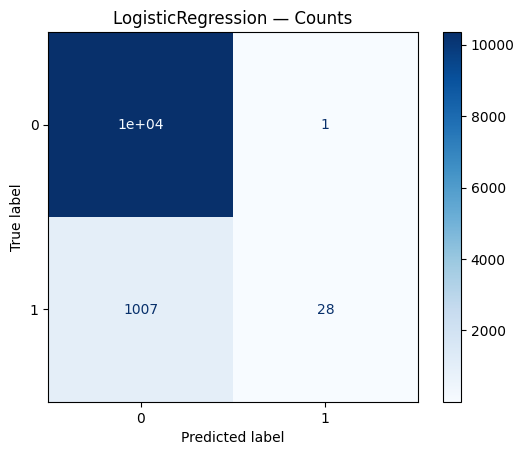

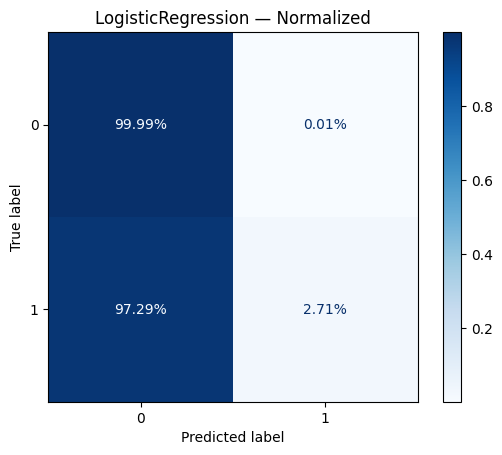

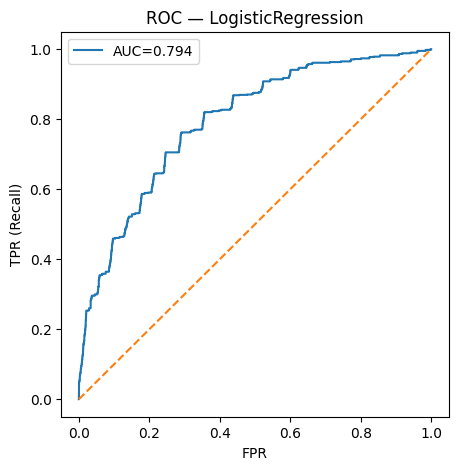

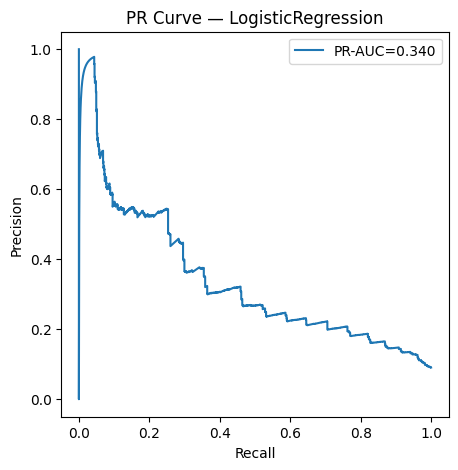

Completed: LogisticRegression
Training: GaussianNB()


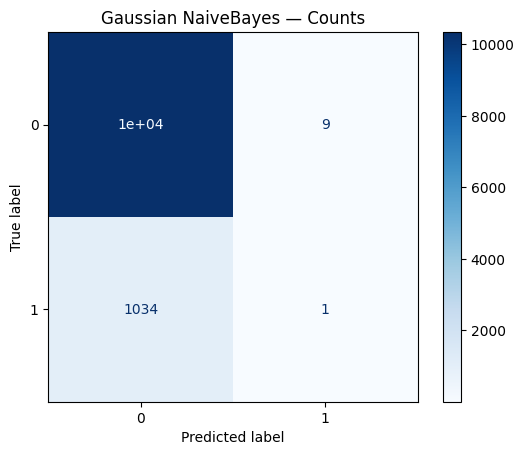

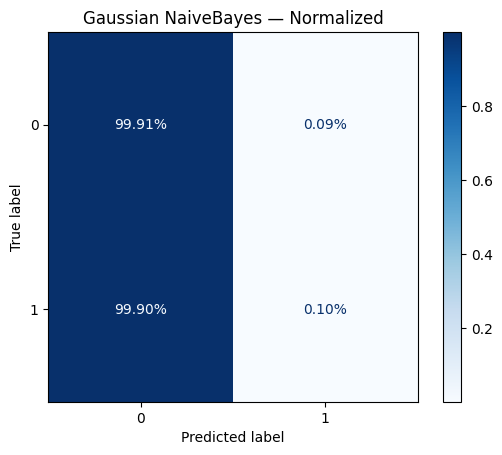

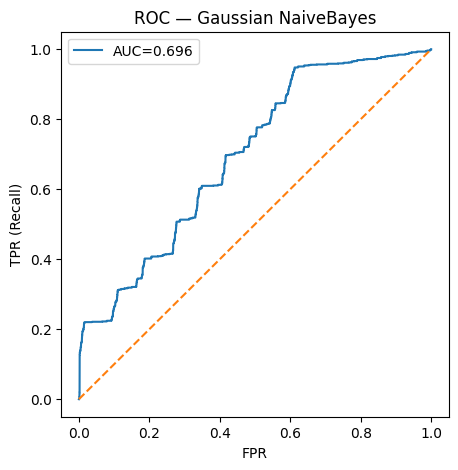

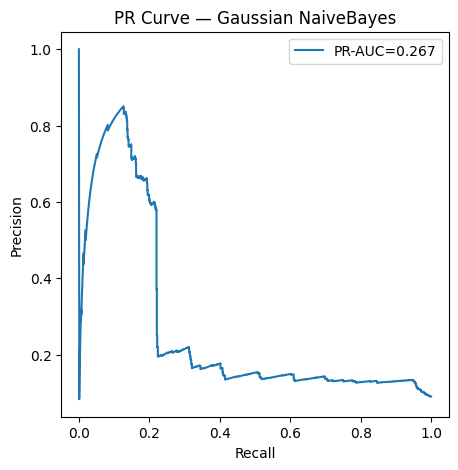

Completed: Gaussian NaiveBayes
Training: DecisionTreeClassifier()


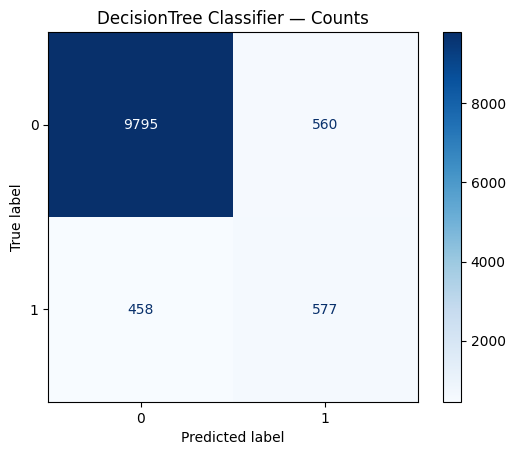

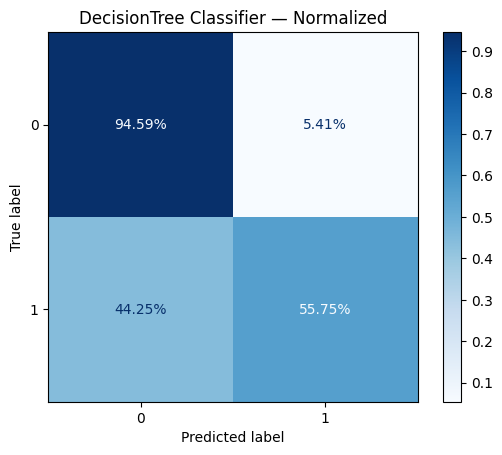

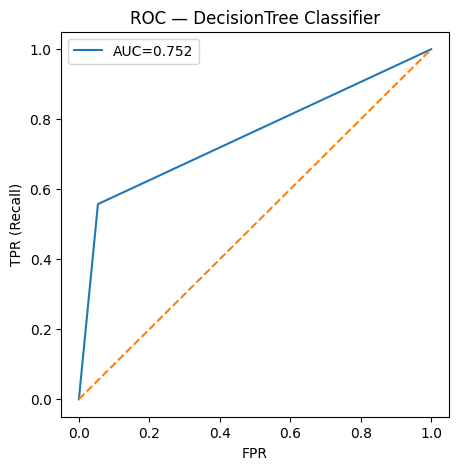

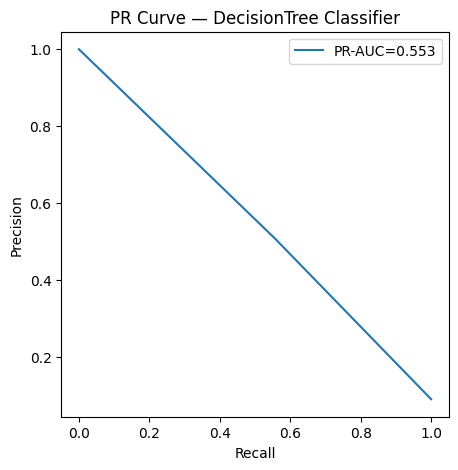

Completed: DecisionTree Classifier
Training: RandomForestClassifier()


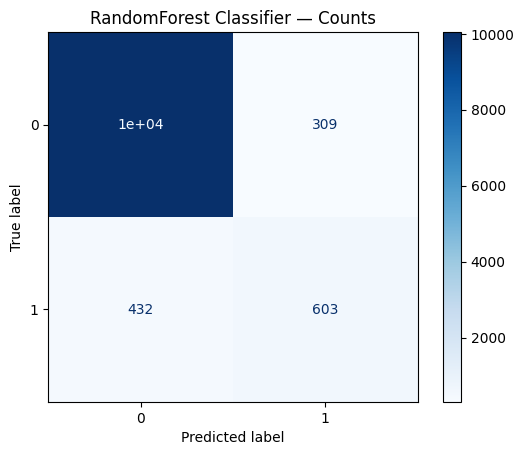

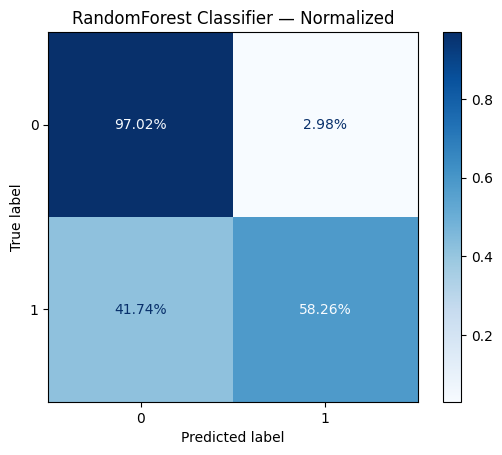

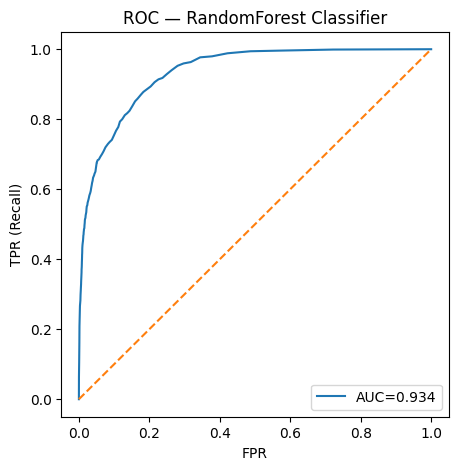

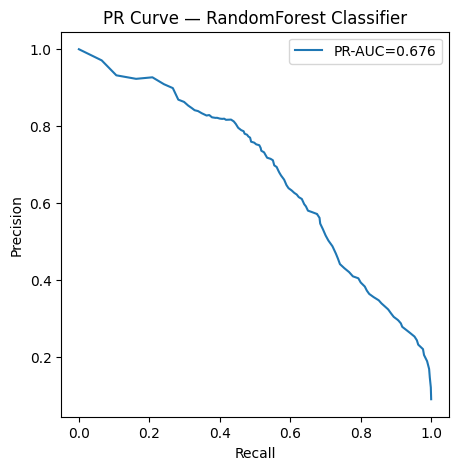

Completed: RandomForest Classifier
Training: GradientBoostingClassifier()


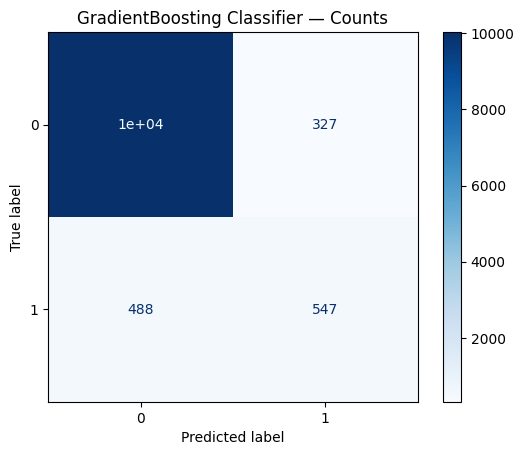

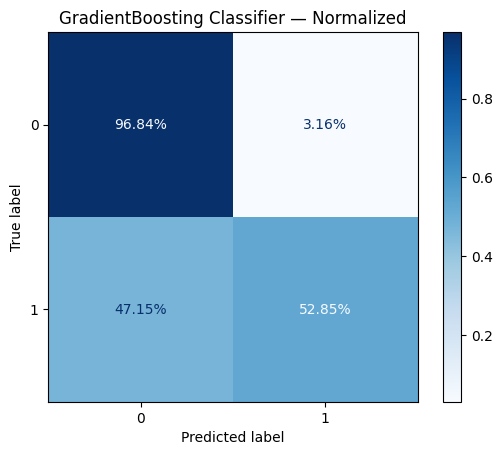

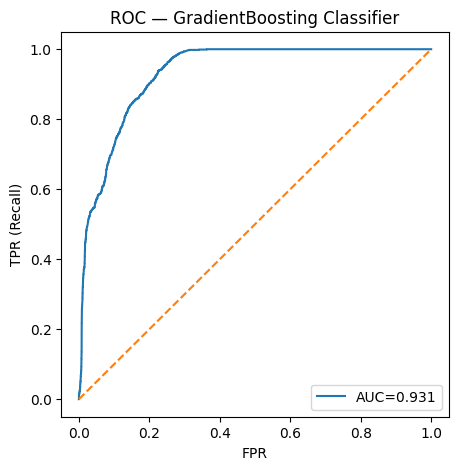

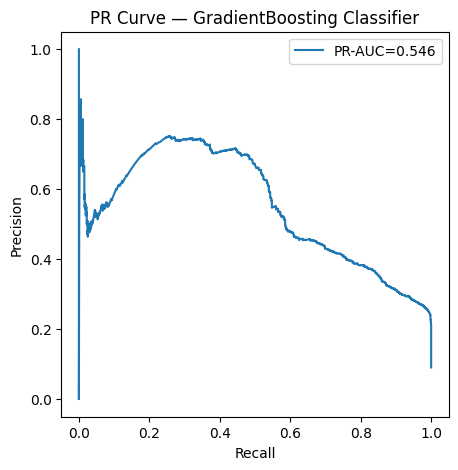

Completed: GradientBoosting Classifier
Training: BaggingClassifier()


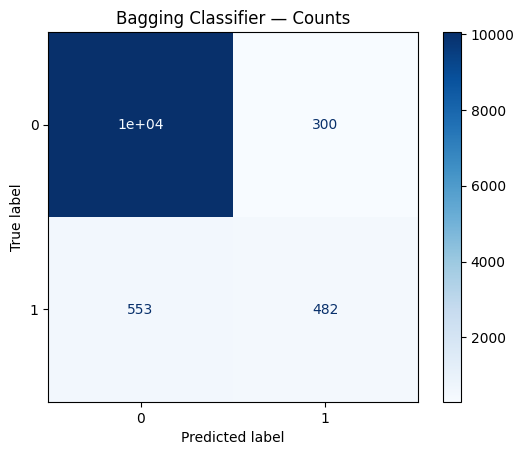

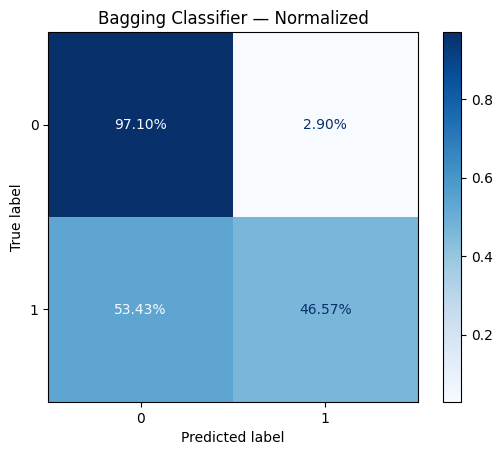

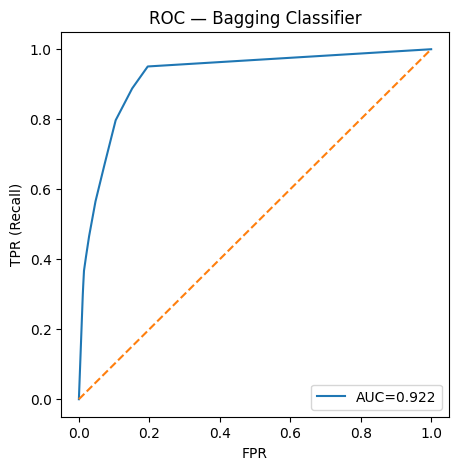

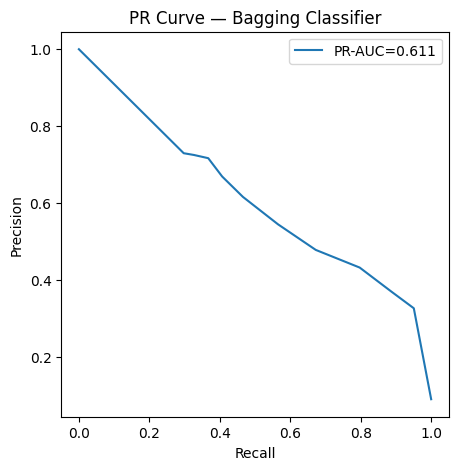

Completed: Bagging Classifier
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


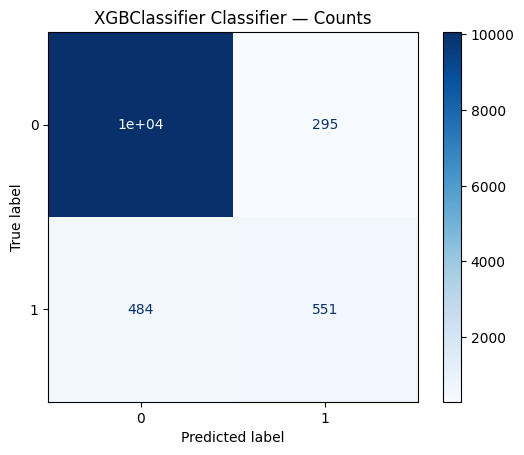

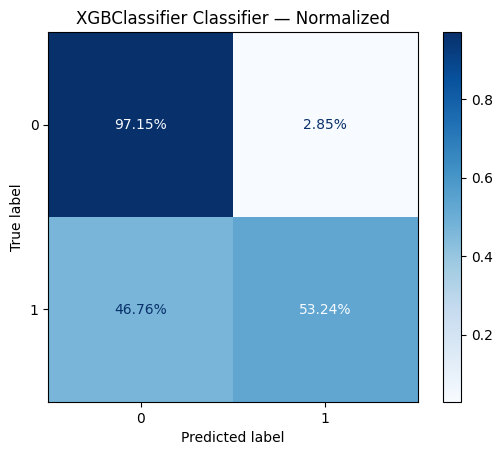

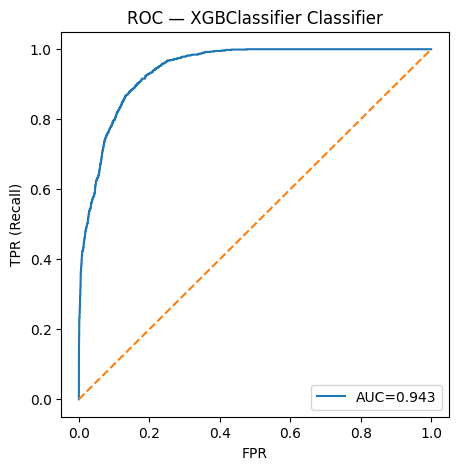

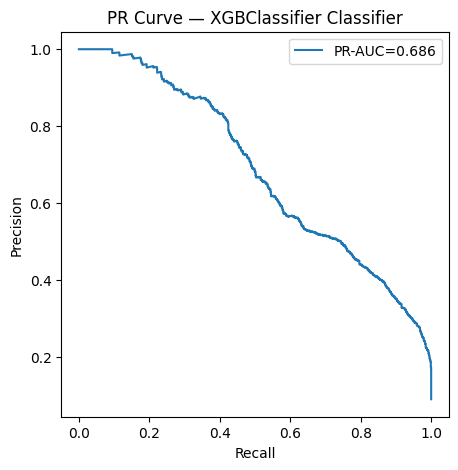

Completed: XGBClassifier Classifier
Training: AdaBoostClassifier()


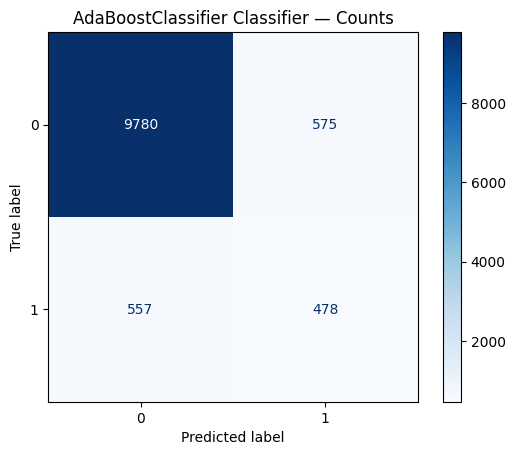

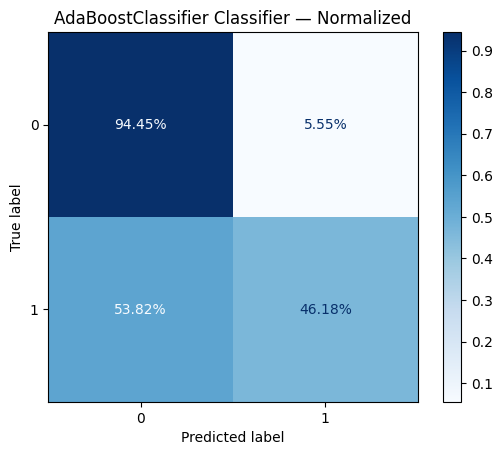

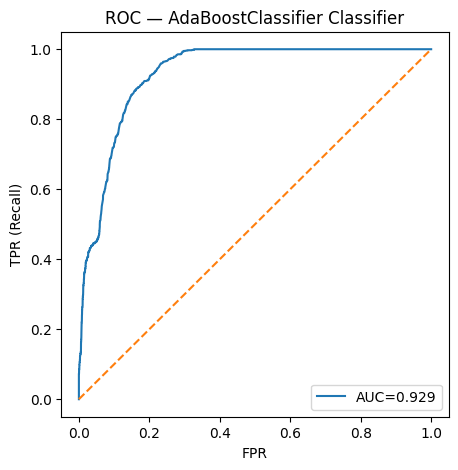

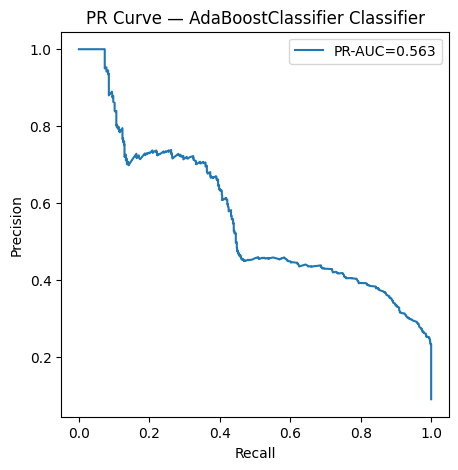

Completed: AdaBoostClassifier Classifier
Training: <catboost.core.CatBoostClassifier object at 0x000001B0E6B0B910>


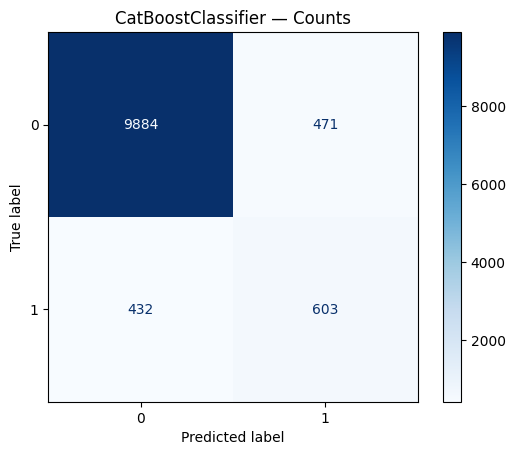

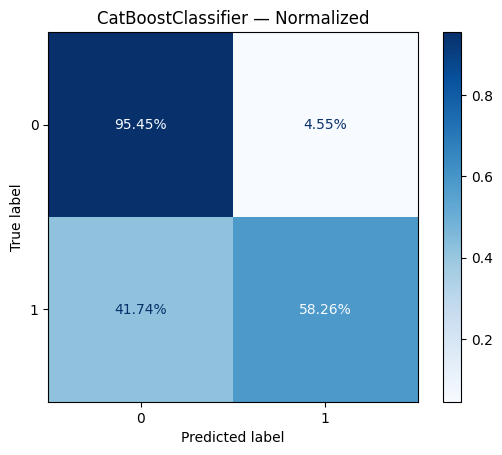

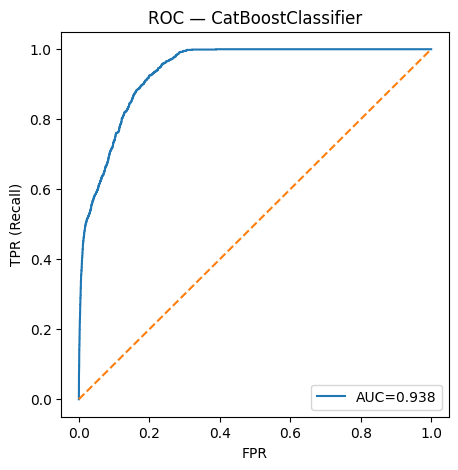

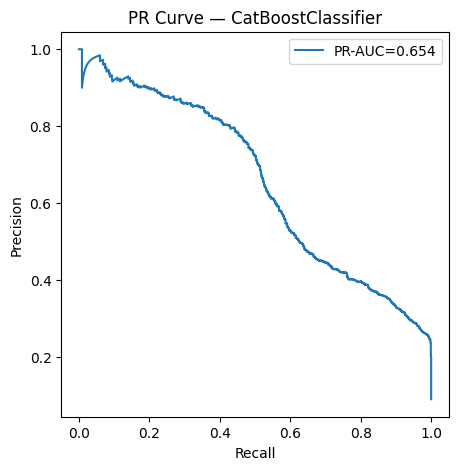

Completed: CatBoostClassifier
Training: LGBMClassifier()
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4142, number of negative: 41415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090919 -> initscore=-2.302464
[LightGBM] [Info] Start training from score -2.302464


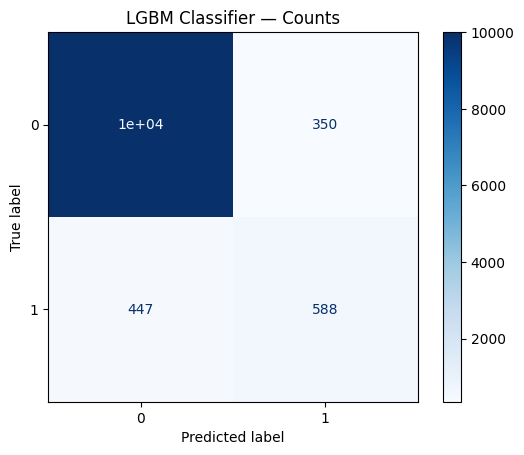

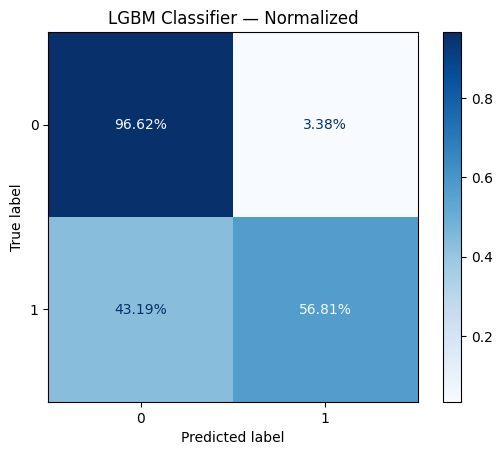

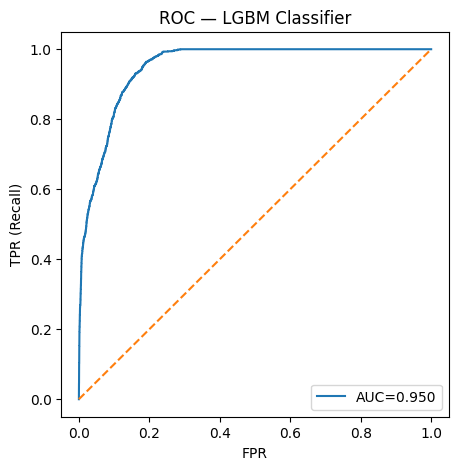

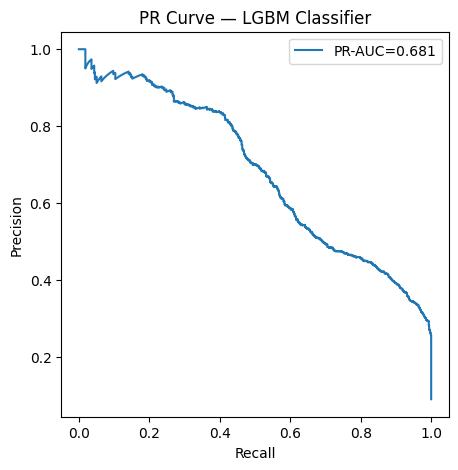

Completed: LGBM Classifier
Training: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())


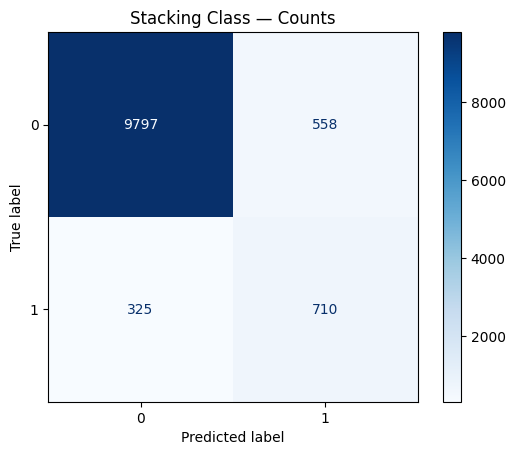

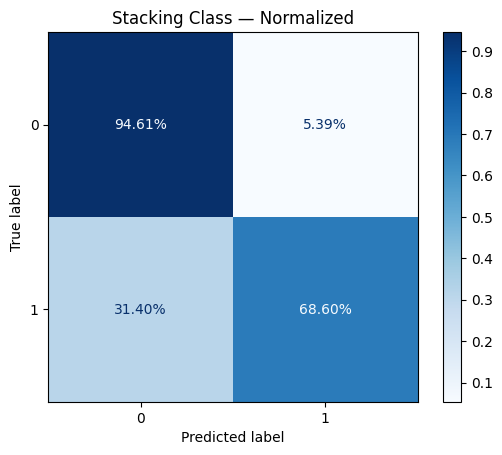

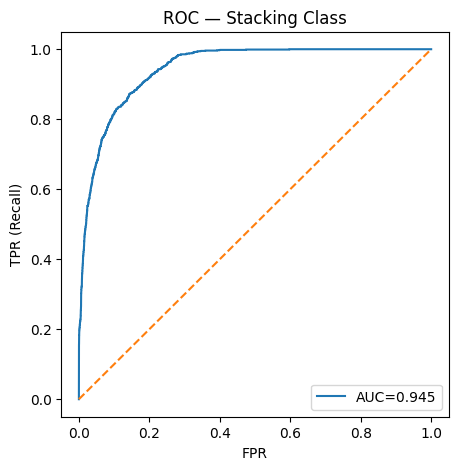

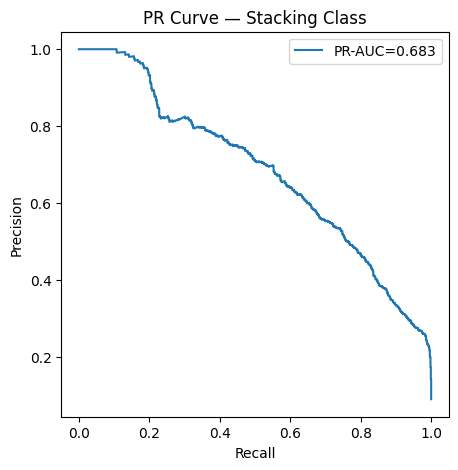

Completed: Stacking Class


Sampling                                         model_name    TP  \
0   Undersampling                               LogisticRegression()    28   
1   Undersampling                                       GaussianNB()     1   
2   Undersampling                           DecisionTreeClassifier()   588   
3   Undersampling                           RandomForestClassifier()   607   
4   Undersampling                       GradientBoostingClassifier()   547   
5   Undersampling                                BaggingClassifier()   523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
7   Undersampling                               AdaBoostClassifier()   478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
9   Undersampling                                   LGBMClassifier()   588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
11          SMOTE                               LogisticRegression()   814   
12          SMOTE                                       GaussianNB()     1   
13          SMOTE                           DecisionTreeClassifier()   529   
14          SMOTE                           RandomForestClassifier()   864   
15          SMOTE                       GradientBoostingClassifier()   975   
16          SMOTE                                BaggingClassifier()   430   
17          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
18          SMOTE                               AdaBoostClassifier()  1027   
19          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
20          SMOTE                                   LGBMClassifier()   829   
21          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   
22       SMOTEENN                               LogisticRegression()   842   
23       SMOTEENN                                       GaussianNB()     5   
24       SMOTEENN                           DecisionTreeClassifier()   612   
25       SMOTEENN                           RandomForestClassifier()   868   
26       SMOTEENN                       GradientBoostingClassifier()  1020   
27       SMOTEENN                                BaggingClassifier()   725   
28       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
29       SMOTEENN                               AdaBoostClassifier()  1007   
30       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
31       SMOTEENN                                   LGBMClassifier()   839   
32       SMOTEENN  StackingClassifier(estimators=[('rf',\n       ...   888   
33      SMOTETEEK                               LogisticRegression()    28   
34      SMOTETEEK                                       GaussianNB()     1   
35      SMOTETEEK                           DecisionTreeClassifier()   577   
36      SMOTETEEK                           RandomForestClassifier()   603   
37      SMOTETEEK                       GradientBoostingClassifier()   547   
38      SMOTETEEK                                BaggingClassifier()   482   
39      SMOTETEEK  XGBClassifier(base_score=None, booster=None, c...   551   
40      SMOTETEEK                               AdaBoostClassifier()   478   
41      SMOTETEEK  <catboost.core.CatBoostClassifier object at 0x...   603   
42      SMOTETEEK                                   LGBMClassifier()   588   
43      SMOTETEEK  StackingClassifier(estimators=[('rf',\n       ...   710   

      FP     TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0      1  10354  1007     0.03     0.00     1.00     0.97      0.91   
1      9  10346  1034     0.00     0.00     1.00     1.00      0.91   
2    546   9809   447     0.57     0.05     0.95     0.43      0.91   
3    322  10033   428     0.59     0.03     0.97     0.41      0.93   
4    327  10028   488     0.53     0.03     0.97     0.47      0.93   
5    313  10042   512     0.51     0.03     0.97     0.49      0.93   
6

In [28]:
X_train4, y_train4, X_test4, y_test4 = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\dataset_joblib_files\dataset_splits.joblib')

models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTETEEK", names[i], models[i],X_train4, y_train4, X_test4,y_test4)
display_report()

In [30]:
report2 = display_report()
report2

Sampling                                         model_name    TP  \
0   Undersampling                               LogisticRegression()    28   
1   Undersampling                                       GaussianNB()     1   
2   Undersampling                           DecisionTreeClassifier()   588   
3   Undersampling                           RandomForestClassifier()   607   
4   Undersampling                       GradientBoostingClassifier()   547   
5   Undersampling                                BaggingClassifier()   523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
7   Undersampling                               AdaBoostClassifier()   478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
9   Undersampling                                   LGBMClassifier()   588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
11          SMOTE                               LogisticRegression()   814   
12          SMOTE                                       GaussianNB()     1   
13          SMOTE                           DecisionTreeClassifier()   529   
14          SMOTE                           RandomForestClassifier()   864   
15          SMOTE                       GradientBoostingClassifier()   975   
16          SMOTE                                BaggingClassifier()   430   
17          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
18          SMOTE                               AdaBoostClassifier()  1027   
19          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
20          SMOTE                                   LGBMClassifier()   829   
21          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   
22       SMOTEENN                               LogisticRegression()   842   
23       SMOTEENN                                       GaussianNB()     5   
24       SMOTEENN                           DecisionTreeClassifier()   612   
25       SMOTEENN                           RandomForestClassifier()   868   
26       SMOTEENN                       GradientBoostingClassifier()  1020   
27       SMOTEENN                                BaggingClassifier()   725   
28       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
29       SMOTEENN                               AdaBoostClassifier()  1007   
30       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
31       SMOTEENN                                   LGBMClassifier()   839   
32       SMOTEENN  StackingClassifier(estimators=[('rf',\n       ...   888   
33      SMOTETEEK                               LogisticRegression()    28   
34      SMOTETEEK                                       GaussianNB()     1   
35      SMOTETEEK                           DecisionTreeClassifier()   577   
36      SMOTETEEK                           RandomForestClassifier()   603   
37      SMOTETEEK                       GradientBoostingClassifier()   547   
38      SMOTETEEK                                BaggingClassifier()   482   
39      SMOTETEEK  XGBClassifier(base_score=None, booster=None, c...   551   
40      SMOTETEEK                               AdaBoostClassifier()   478   
41      SMOTETEEK  <catboost.core.CatBoostClassifier object at 0x...   603   
42      SMOTETEEK                                   LGBMClassifier()   588   
43      SMOTETEEK  StackingClassifier(estimators=[('rf',\n       ...   710   

      FP     TN    FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
0      1  10354  1007     0.03     0.00     1.00     0.97      0.91   
1      9  10346  1034     0.00     0.00     1.00     1.00      0.91   
2    546   9809   447     0.57     0.05     0.95     0.43      0.91   
3    322  10033   428     0.59     0.03     0.97     0.41      0.93   
4    327  10028   488     0.53     0.03     0.97     0.47      0.93   
5    313  10042   512     0.51     0.03     0.97     0.49      0.93   
6

In [32]:
dump((report2), 'under_over_sampling_results.joblib')

['under_over_sampling_results.joblib']

In [4]:
from joblib import load
report2 = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\notebooks\under_over_sampling_results.joblib')

report2

Sampling                                         model_name    TP  \
0   Undersampling                               LogisticRegression()    28   
1   Undersampling                                       GaussianNB()     1   
2   Undersampling                           DecisionTreeClassifier()   588   
3   Undersampling                           RandomForestClassifier()   607   
4   Undersampling                       GradientBoostingClassifier()   547   
5   Undersampling                                BaggingClassifier()   523   
6   Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
7   Undersampling                               AdaBoostClassifier()   478   
8   Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
9   Undersampling                                   LGBMClassifier()   588   
10  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
11          SMOTE                               LogisticRegression()   814   
12          SMOTE                                       GaussianNB()     1   
13          SMOTE                           DecisionTreeClassifier()   529   
14          SMOTE                           RandomForestClassifier()   864   
15          SMOTE                       GradientBoostingClassifier()   975   
16          SMOTE                                BaggingClassifier()   430   
17          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
18          SMOTE                               AdaBoostClassifier()  1027   
19          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
20          SMOTE                                   LGBMClassifier()   829   
21          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   
22       SMOTEENN                               LogisticRegression()   842   
23       SMOTEENN                                       GaussianNB()     5   
24       SMOTEENN                           DecisionTreeClassifier()   612   
25       SMOTEENN                           RandomForestClassifier()   868   
26       SMOTEENN                       GradientBoostingClassifier()  1020   
27       SMOTEENN                                BaggingClassifier()   725   
28       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
29       SMOTEENN                               AdaBoostClassifier()  1007   
30       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
31       SMOTEENN                                   LGBMClassifier()   839   
32       SMOTEENN  StackingClassifier(estimators=[('rf',\n       ...   888   
33      SMOTETEEK                               LogisticRegression()    28   
34      SMOTETEEK                                       GaussianNB()     1   
35      SMOTETEEK                           DecisionTreeClassifier()   577   
36      SMOTETEEK                           RandomForestClassifier()   603   
37      SMOTETEEK                       GradientBoostingClassifier()   547   
38      SMOTETEEK                                BaggingClassifier()   482   
39      SMOTETEEK  XGBClassifier(base_score=None, booster=None, c...   551   
40      SMOTETEEK                               AdaBoostClassifier()   478   
41      SMOTETEEK  <catboost.core.CatBoostClassifier object at 0x...   603   
42      SMOTETEEK                                   LGBMClassifier()   588   
43      SMOTETEEK  StackingClassifier(estimators=[('rf',\n       ...   710   

      FP     TN    FN   TP_rate   FP_rate   TN_rate   FN_rate  accuracy  \
0      1  10354  1007  0.027053  0.000097  0.999903  0.972947  0.911501   
1      9  10346  1034  0.000966  0.000869  0.999131  0.999034  0.908428   
2    546   9809   447  0.568116  0.052728  0.947272  0.431884  0.912818   
3    322  10033   428  0.586473  0.031096  0.968904  0.413527  0.934153   
4    327  10028   488  0.528502  0.031579  0.968421  0.471498  0.928446   
5    313  10042   512  0.505314  0.030227  0.969

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
report1 = pd.DataFrame(df_original)
report2 = pd.DataFrame(report2)

report3 = pd.concat([report1, report2], ignore_index=True)

report3

Sampling                                         model_name    TP  \
0            None                               LogisticRegression()     0   
1            None                                       GaussianNB()     0   
2            None                           DecisionTreeClassifier()   217   
3            None                           RandomForestClassifier()   139   
4            None                       GradientBoostingClassifier()   119   
5            None                                BaggingClassifier()   150   
6            None  XGBClassifier(base_score=None, booster=None, c...   132   
7            None                               AdaBoostClassifier()    60   
8            None  <catboost.core.CatBoostClassifier object at 0x...   167   
9            None                                   LGBMClassifier()    96   
10  Undersampling                               LogisticRegression()    28   
11  Undersampling                                       GaussianNB()     1   
12  Undersampling                           DecisionTreeClassifier()   588   
13  Undersampling                           RandomForestClassifier()   607   
14  Undersampling                       GradientBoostingClassifier()   547   
15  Undersampling                                BaggingClassifier()   523   
16  Undersampling  XGBClassifier(base_score=None, booster=None, c...   551   
17  Undersampling                               AdaBoostClassifier()   478   
18  Undersampling  <catboost.core.CatBoostClassifier object at 0x...   603   
19  Undersampling                                   LGBMClassifier()   588   
20  Undersampling  StackingClassifier(estimators=[('rf',\n       ...   710   
21          SMOTE                               LogisticRegression()   814   
22          SMOTE                                       GaussianNB()     1   
23          SMOTE                           DecisionTreeClassifier()   529   
24          SMOTE                           RandomForestClassifier()   864   
25          SMOTE                       GradientBoostingClassifier()   975   
26          SMOTE                                BaggingClassifier()   430   
27          SMOTE  XGBClassifier(base_score=None, booster=None, c...  1035   
28          SMOTE                               AdaBoostClassifier()  1027   
29          SMOTE  <catboost.core.CatBoostClassifier object at 0x...   941   
30          SMOTE                                   LGBMClassifier()   829   
31          SMOTE  StackingClassifier(estimators=[('rf',\n       ...   834   
32       SMOTEENN                               LogisticRegression()   842   
33       SMOTEENN                                       GaussianNB()     5   
34       SMOTEENN                           DecisionTreeClassifier()   612   
35       SMOTEENN                           RandomForestClassifier()   868   
36       SMOTEENN                       GradientBoostingClassifier()  1020   
37       SMOTEENN                                BaggingClassifier()   725   
38       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
39       SMOTEENN                               AdaBoostClassifier()  1007   
40       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
41       SMOTEENN                                   LGBMClassifier()   839   
42       SMOTEENN  StackingClassifier(estimators=[('rf',\n       ...   888   
43      SMOTETEEK                               LogisticRegression()    28   
44      SMOTETEEK                                       GaussianNB()     1   
45      SMOTETEEK                           DecisionTreeClassifier()   577   
46      SMOTETEEK                           RandomForestClassifier()   603   
47      SMOTETEEK                       GradientBoostingClassifier()   547   
48      SMOTETEEK                                BaggingClassifier()   482   
49      SMOTETEEK  XGBClassifier(base_score=None, booster=None, c...   551   
50      SMOTETEEK              

In [12]:
import joblib
from joblib import dump
dump((report3), 'all_models_sampling_compare.joblib')

['all_models_sampling_compare.joblib']

# Model Evaluation & Selection Strategy for Loan Approval Systems

When evaluating **40+ experiment iterations** (varying models and sampling techniques like SMOTE), use the following hierarchy to identify the optimal production model.

---

### 1. The Global Ranker: PR AUC (Precision-Recall Area Under Curve)
**Why use this to rank the 40 results?**
* **Threshold Independence:** Unlike Recall, which is calculated at a single probability (0.5), PR AUC evaluates performance across **all possible thresholds**.
* **Imbalance Robustness:** In lending/insurance, the "Positive" class (defaults) is rare. PR AUC focuses on the minority class and isn't "fooled" by a high number of True Negatives.
* **Sampling Validation:** Sampling often inflates Recall at the expense of Precision. PR AUC captures this trade-off, identifying which model is a "better learner" rather than just the most aggressive one.



---

### 2. The Business Decision Metric: $F_2$ Score
**Why use this for final selection?**
* **Risk Weighting:** In credit/insurance, the cost of a **False Negative** (missing a high-risk applicant) is significantly higher than a **False Positive** (flagging a good one).
* **Weighted Recall:** The $F_2$ score applies a $\beta = 2$ weighting, valuing **Recall twice as much as Precision**. This ensures you catch as much risk as possible while maintaining a functional level of Precision.

---

### 3. Why Recall alone is insufficient
* **The "Zero-Intelligence" Trap:** A model that approves everyone achieves **100% Recall** but has **0% utility** for the business.
* **Lack of Nuance:** High Recall is only valuable if the associated "False Alarm" rate (Precision drop) is manageable.

---

### Recommended Selection Workflow
1. **Rank** all 40 runs by **PR AUC** to find the most stable underlying models.
2. **Filter** the top 5 models based on the highest AUC.
3. **Calculate $F_2$** for these 5 at your specific operational threshold.
4. **Deploy** the model with the highest **$F_2$ score**.

In [8]:
top_five = report3.nlargest(5, 'pr_auc')

top_five

Sampling                                         model_name    TP  \
40       SMOTEENN  <catboost.core.CatBoostClassifier object at 0x...   977   
38       SMOTEENN  XGBClassifier(base_score=None, booster=None, c...  1020   
36       SMOTEENN                       GradientBoostingClassifier()  1020   
35       SMOTEENN                           RandomForestClassifier()   868   
13  Undersampling                           RandomForestClassifier()   607   

      FP     TN   FN  TP_rate  FP_rate  TN_rate  FN_rate  accuracy  \
40  1655   8700   58     0.94     0.16     0.84     0.06      0.85   
38  2615   7740   15     0.99     0.25     0.75     0.01      0.77   
36  2113   8242   15     0.99     0.20     0.80     0.01      0.81   
35   857   9498  167     0.84     0.08     0.92     0.16      0.91   
13   322  10033  428     0.59     0.03     0.97     0.41      0.93   

    balanced_accuracy  recall  precision   f1  f0.5  f2.0  roc_auc  pr_auc  
40               0.89    0.94       0.37 0.53  0.42  0.72     0.96    0.75  
38               0.87    0.99       0.28 0.44  0.33  0.66     0.96    0.74  
36               0.89    0.99       0.33 0.49  0.38  0.70     0.96    0.72  
35               0.88    0.84       0.50 0.63  0.55  0.74     0.95    0.69  
13               0.78    0.59       0.65 0.62  0.64  0.60     0.94    0.69

### Final Model Selection Comparison

| ID | Model Strategy | PR AUC | F2 Score | Recall | Precision | Logic |
|:---|:---|:---|:---|:---|:---|:---|
| **40** | **CatBoost + SMOTEENN** | **0.75** | **0.72** | 0.94 | 0.37 | **Winner:** Best balance of risk detection and precision. |
| 38 | XGBoost + SMOTEENN | 0.74 | 0.66 | 0.99 | 0.28 | Too many false alarms (Low Precision). |
| 35 | Random Forest + SMOTEENN| 0.69 | 0.74 | 0.84 | 0.50 | Lower PR AUC; less stable across thresholds. |
| 13 | RF + Undersampling | 0.69 | 0.60 | 0.59 | 0.65 | Failed to capture enough risk (Low Recall). |

**Selection:** **Model 40** is the optimal choice for production as it maximizes the PR AUC and maintains a high F2 score without completely destroying Precision.